# Notebook to extract hidden-states and attention heads activations from gpt2 model predictions

In [1]:
import os
import glob
import torch
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import GPT2Extractor
from sklearn.preprocessing import StandardScaler
from tokenizer import tokenize
#from utils import set_seed
from numpy import linalg as la
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

gpt2_utils2 = __import__('07_gpt2')


In [2]:
def check_folder(path):
    """Create adequate folders if necessary."""
    try:
        if not os.path.isdir(path):
            check_folder(os.path.dirname(path))
            os.mkdir(path)
    except:
        pass

In [3]:
def transform(activations, path, name, run_index, n_layers_hidden=13, n_layers_attention=12, hidden_size=768):
    assert activations.values.shape[1] == (n_layers_hidden + n_layers_attention) * hidden_size
    indexes = [[index*hidden_size, (index+1)*hidden_size] for index in range(n_layers_hidden + n_layers_attention)]
    for order in [2]: # np.inf
        matrices = []
        for i, index in enumerate(indexes):
            matrix = activations.values[:, index[0]:index[1]]
            #with_std = True if order=='std' else False
            #scaler = StandardScaler(with_mean=True, with_std=with_std)
            #scaler.fit(matrix)
            #matrix = scaler.transform(matrix)
            if order is not None and order != 'std':
                matrix = matrix / np.mean(la.norm(matrix, ord=order, axis=1))
            matrices.append(matrix)
        matrices = np.hstack(matrices)
        new_data = pd.DataFrame(matrices, columns=activations.columns)
        new_path = path + '_norm-' + str(order).replace('np.', '')
        check_folder(new_path)
        new_data.to_csv(os.path.join(new_path, name + '_run{}.csv'.format(run_index + 1)), index=False)


Defining variables:

In [4]:
template = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/text_english_run*.txt' # path to text input
language = 'english'

Creating iterator for each run:

In [5]:
template = '/Users/alexpsq/Code/Parietal/data/text_english_run*.txt' # path to text input


In [5]:
paths = sorted(glob.glob(template))

In [6]:
iterator_list = [tokenize(path, language, train=False) for path in paths]

100%|██████████| 207/207 [00:00<00:00, 333162.29it/s]


In [7]:
import gpt2_utils
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

lengths = []

for index in range(9):
    batches, indexes = gpt2_utils.batchify_with_detailed_indexes(
                iterator_list[index], 
                1, 
                3, 
                'gpt2', 
                max_length=512)
    #lengths.append(np.array(sorted([len(item.split()) for item in batches])))
    lengths.append(np.array(sorted([len(tokenizer.tokenize(item)) for item in batches])))

    sns.boxplot(lengths[-1])
    plt.show()
    print()

print(np.mean(np.array([np.mean(item) for item in lengths])))
print(np.median(np.array([np.median(item) for item in lengths])))
print(np.mean(np.array([np.median(item) for item in lengths])))

LookupError: unknown encoding:  Once , when I was six years old , I saw a magnificent picture in a book about the primeval forest called ‘ Real - life Stories . ’ It showed a boa constrictor swallowing a wild animal . Here is a copy of the drawing .

In [9]:
from transformers import GPT2Tokenizer

config = {
    'number_of_sentence': 1, 
    'number_of_sentence_before': 10, 
    'attention_length_before': 15, 
    'stop_attention_at_sent_before': 1,
}



tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
#t2 = GPT2Tokenizer.from_pretrained('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/models/english/GPT-2/')

In [56]:
print(tokenizer.encode(" <|endoftext|> <s> <mask> . <unk> </s> <pad> <|endoftext|>").ids)
print()
print(tokenizer2.encode("<|endoftext|> <s> <mask> . <unk> </s> <pad> <|endoftext|>"))

print(tokenizer.encode("<|endoftext|> <s> <mask> . <unk> </s> <pad> <|endoftext|>").tokens)
print()
print(tokenizer2.tokenize("<|endoftext|> <s> <mask> . <unk> </s> <pad> <|endoftext|>"))

print(tokenizer.convert_tokens_to_ids(tokenizer.encode("<|endoftext|> <s> <mask> . <unk> </s> <pad> <|endoftext|>").tokens))

[568, 96, 4529, 6773, 681, 1096, 96, 34, 225, 0, 225, 4, 272, 225, 3, 225, 2, 225, 1, 568, 96, 4529, 6773, 681, 1096, 96, 34]

[50256, 1279, 82, 29, 1279, 27932, 29, 764, 1279, 2954, 29, 7359, 82, 29, 1279, 15636, 29, 220, 50256]
['<', '|', 'end', 'of', 'te', 'xt', '|', '>', 'Ġ', '<s>', 'Ġ', '<mask>', 'Ġ.', 'Ġ', '<unk>', 'Ġ', '</s>', 'Ġ', '<pad>', 'Ġ<', '|', 'end', 'of', 'te', 'xt', '|', '>']

['<|endoftext|>', 'Ġ<', 's', '>', 'Ġ<', 'mask', '>', 'Ġ.', 'Ġ<', 'unk', '>', 'Ġ</', 's', '>', 'Ġ<', 'pad', '>', 'Ġ', '<|endoftext|>']


AttributeError: 'ByteLevelBPETokenizer' object has no attribute 'convert_tokens_to_ids'

In [25]:
from transformers import GPT2Model, BertModel, GPT2Config, BertConfig, BertTokenizer
import gpt2_utils

#configuration_gpt2 = GPT2Config(output_hidden_states=True, 
#                                                    output_attentions=True,
#                                                    pad_token_id=tokenizer.eos_token_id)

path = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/models/english/gpt2_L-6_H-256_A-4/config.json'
parameters = gpt2_utils.read_yaml(path)
configuration_gpt2 = GPT2Config(**parameters, pad_token_id=tokenizer.eos_token_id)

path = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/models/english/uncased_L-6_H-256_A-4/config.json'
parameters = gpt2_utils.read_yaml(path)
configuration_bert = BertConfig(**parameters)
gpt2_utils.set_seed(1111)

gpt2 = GPT2Model(configuration_gpt2)
gpt2_utils.set_seed(1111)
bert = BertModel(configuration_bert)

In [26]:
bert.embeddings.word_embeddings.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0056, -0.0042,  0.0274,  ..., -0.0043, -0.0092,  0.0182],
        [-0.0270,  0.0020, -0.0061,  ...,  0.0201, -0.0050,  0.0085],
        ...,
        [ 0.0086, -0.0112,  0.0204,  ...,  0.0016, -0.0035, -0.0057],
        [ 0.0192, -0.0199, -0.0272,  ...,  0.0014, -0.0033,  0.0197],
        [ 0.0110, -0.0055,  0.0011,  ..., -0.0127,  0.0033,  0.0010]],
       requires_grad=True)

In [24]:
print(bert.embeddings.word_embeddings.weight)
print(gpt2.h[3].mlp.c_fc.weight)

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0098,  0.0111, -0.0044,  ..., -0.0291, -0.0030, -0.0099],
        [-0.0241,  0.0291,  0.0093,  ...,  0.0150, -0.0038, -0.0222],
        ...,
        [ 0.0169,  0.0133, -0.0376,  ..., -0.0004,  0.0002,  0.0022],
        [-0.0249,  0.0165,  0.0100,  ...,  0.0052, -0.0138,  0.0242],
        [ 0.0243, -0.0059,  0.0065,  ...,  0.0397,  0.0130, -0.0288]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0235, -0.0184, -0.0397,  ..., -0.0198, -0.0215, -0.0061],
        [-0.0298,  0.0270, -0.0184,  ...,  0.0151, -0.0382, -0.0437],
        [ 0.0161, -0.0034,  0.0326,  ...,  0.0065,  0.0054, -0.0275],
        ...,
        [ 0.0323, -0.0110,  0.0045,  ...,  0.0222, -0.0176,  0.0419],
        [ 0.0272, -0.0165, -0.0061,  ..., -0.0213,  0.0063, -0.0004],
        [ 0.0030, -0.0100, -0.0267,  ...,  0.0176,  0.0088,  0.0131]],
       requires_grad=True)


In [10]:
#import utils
#config = {'stop_attention_at_sent': None,
#          'number_of_sentence': 1,
#          'stop_attention_before_sent': 0
#         }
#
#batches, indexes = utils.batchify_with_detailed_indexes(
#            iterator_list[0], 
#            config['number_of_sentence'], 
#            20, 
#            'gpt2', 
#            1024,
#            config['stop_attention_at_sent'],
#            config['stop_attention_before_sent'],
#    True
#        )
#
#
#
#indexes_tmp = [(indexes[i][-config['number_of_sentence']][0], indexes[i][-1][1]) for i in range(len(indexes))]
#indexes_tmp[0] = (indexes[0][0][0], indexes[0][-1][1])
#print(indexes_tmp)
#for i in indexes_tmp:
#    print(i[1]-i[0])
#
#
#
#from transformers import GPT2Tokenizer, GPT2Model
#tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
#model = GPT2Model.from_pretrained('gpt2', output_hidden_states=True)
#
#m = 0
#hidden_states_activations = []
#
#for index, batch in enumerate(batches):
#    batch = batch.strip() # Remove trailing character
#    #batch = '<|endoftext|> ' + batch + ' <|endoftext|>'
#    
#    tokenized_text = tokenizer.tokenize(batch, add_prefix_space=False)
#    inputs_ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_text)])
#    attention_mask = torch.tensor([[1 for x in tokenized_text]])
#
#    if (config['stop_attention_at_sent'] is not None) and (index > 0):
#        attention_mask[:, :1 + indexes[index][-config['stop_attention_at_sent']-config['number_of_sentence']][0]] = 0
#        if self.config['stop_attention_before_sent'] < 0:
#            attention_mask[:, 1 + indexes[index][-config['stop_attention_at_sent']-config['number_of_sentence']][0]: 1 + indexes[index][-config['stop_attention_at_sent']-config['number_of_sentence']][0]-config['stop_attention_before_sent']] = 0
#        elif self.config['stop_attention_before_sent'] > 0:
#            attention_mask[:, 1 + indexes[index][-config['stop_attention_at_sent']-config['number_of_sentence']][0]-config['stop_attention_before_sent']: 1 + indexes[index][-config['stop_attention_at_sent']-config['number_of_sentence']][0]] = 1
#    mapping = utils.match_tokenized_to_untokenized(tokenized_text, batch)
#    
#    with torch.no_grad():
#        encoded_layers = model(inputs_ids, attention_mask=attention_mask) 
#    hidden_states_activations_ = np.vstack(encoded_layers[2]) # retrieve all the hidden states (dimension = layer_count * len(tokenized_text) * feature_count)
#    a = utils.extract_activations_from_token_activations(hidden_states_activations_, mapping, indexes_tmp[index])
#    #m += len(tokenized_text[indexes_tmp[index][0]:indexes_tmp[index][1]])
#    m += len(a)
#    #print(len(a), a[0].shape)
#    #print(len(tokenized_text), indexes_tmp[index][0], indexes_tmp[index][1])
#    #print(tokenized_text[indexes_tmp[index][0]:indexes_tmp[index][1]])
#    #print(np.array(tokenized_text)[attention_mask.detach().numpy()[0].astype(bool)])
#    #print(mapping)
#    key_start = None
#    key_stop = None
#    for key_, value in mapping.items(): 
#        if (value[0])== (indexes_tmp[index][0]): #because we added <|endoftext|> token at the beginning
#            key_start = key_
#
#    #print(key_start, len(mapping.keys()))
#    #print(tokenized_text)
#    for word_index in range(key_start, len(mapping.keys())): # len(mapping.keys()) - 1
#        print([index for index in mapping[word_index]])
#    #print()
#    #a=input()
#    #if a!='a':
#    #    break
#print(m)

## Activation extraction

In [11]:
pretrained_gpt2_models = [
#"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/models/english/gpt2_L-1_H-768_Gutenberg/config.json",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-1",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-2",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-3",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-4",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-5",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-6",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-7",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-8",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-0_window/Backup2/end-epoch-0_split-1",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-0_window/Backup2/end-epoch-0_split-2",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-0_window/Backup2/end-epoch-0_split-3",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-0_window/Backup2/end-epoch-0_split-4",

]
pretrained_gpt2_tokenizer_list = [
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/gpt2_tokenizer",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/gpt2_tokenizer",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/gpt2_tokenizer",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/gpt2_tokenizer",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/gpt2_tokenizer",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/gpt2_tokenizer",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/gpt2_tokenizer",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/gpt2_tokenizer",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-0_window/gpt2_tokenizer",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-0_window/gpt2_tokenizer",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-0_window/gpt2_tokenizer",
"../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-0_window/gpt2_tokenizer",

]
names = [
"gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-1",
"gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-2",
"gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-3",
"gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-4",
"gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-5",
"gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-6",
"gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-7",
"gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-8",
"gpt2_L-4_H-768_trained-corrected_context-0_window_pre-20_1_end-epoch-0_split-1",
"gpt2_L-4_H-768_trained-corrected_context-0_window_pre-20_1_end-epoch-0_split-2",
"gpt2_L-4_H-768_trained-corrected_context-0_window_pre-20_1_end-epoch-0_split-3",
"gpt2_L-4_H-768_trained-corrected_context-0_window_pre-20_1_end-epoch-0_split-4",
         ]
config_paths = pretrained_gpt2_models # [None] * 34
saving_path_folders = [
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-1".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-2".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-3".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-4".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-5".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-6".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-7".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-8".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_L-4_H-768_trained-corrected_context-0_window_pre-20_1_end-epoch-0_split-1".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_L-4_H-768_trained-corrected_context-0_window_pre-20_1_end-epoch-0_split-2".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_L-4_H-768_trained-corrected_context-0_window_pre-20_1_end-epoch-0_split-3".format(language),
"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/gpt2_L-4_H-768_trained-corrected_context-0_window_pre-20_1_end-epoch-0_split-4".format(language),
]
prediction_types = ['truncated'] * len(pretrained_gpt2_models)
number_of_sentence_list = [1] * len(pretrained_gpt2_models)
number_of_sentence_before_list = [20] * len(pretrained_gpt2_models)
attention_length_before_list = [1000] * len(pretrained_gpt2_models)
n_layers_hidden_list = [4] * len(names)
hidden_size_list = [768] * len(pretrained_gpt2_models)

stop_attention_at_sent_list = [None] * len(pretrained_gpt2_models)
stop_attention_before_sent_list = [0] * len(pretrained_gpt2_models)

context_length_list = [15, 15, 15, 15, 15, 15, 15, 15, 0, 0, 0, 0]
max_length_list = [i+5 for i in context_length_list]



In [12]:
output_attentions = False
output_hidden_states = True

In [13]:
for index, gpt2_model in enumerate(pretrained_gpt2_models):
    extractor = GPT2Extractor(gpt2_model, 
                              language, 
                              names[index], 
                              prediction_types[index],
                              output_hidden_states=output_hidden_states, 
                              output_attentions=output_attentions,
                              attention_length_before=attention_length_before_list[index],
                              config_path=config_paths[index],
                              max_length=max_length_list[index],
                              context_length=context_length_list[index],
                              randomize=False,
                              number_of_sentence=number_of_sentence_list[index], 
                              number_of_sentence_before=number_of_sentence_before_list[index],
                              stop_attention_at_sent_before=stop_attention_at_sent_list[index],
                              stop_attention_before_sent=stop_attention_before_sent_list[index],
                              pretrained_gpt2_tokenizer=tokenizer
                             )
    print(extractor.name, ' - Extracting activations ...')
    for run_index, iterator in tqdm(enumerate(iterator_list)):
        gc.collect()
        print("############# Run {} #############".format(run_index + 1))
        activations  = extractor.extract_activations(iterator, language)
        hidden_states_activations = activations[0]
        attention_heads_activations = activations[1]
        #activations = pd.concat([hidden_states_activations, attention_heads_activations], axis=1)

        transform(
            hidden_states_activations, 
            saving_path_folders[index], 
            'activations', 
            run_index=run_index,
            n_layers_hidden=n_layers_hidden_list[index]+1,
            n_layers_attention=0, 
            hidden_size=hidden_size_list[index])
        
        #transform(cls_activations, saving_path_folders[index], 'cls')
        #transform(sep_activations, saving_path_folders[index], 'sep')
        
        #check_folder(saving_path_folders[index])
        #hidden_states_activations.to_csv(os.path.join(saving_path_folders[index], 'activations_run{}.csv'.format(run_index + 1)), index=False)
        #activations.to_csv(os.path.join(saving_path_folders[index], 'activations_run{}.csv'.format(run_index + 1)), index=False)
        #cls_activations.to_csv(os.path.join(saving_path_folders[index], 'cls_run{}.csv'.format(run_index + 1)), index=False)
        #sep_activations.to_csv(os.path.join(saving_path_folders[index], 'sep_run{}.csv'.format(run_index + 1)), index=False)
        del activations
        del hidden_states_activations
        #del attention_heads_activations

Some weights of the model checkpoint at ../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-1 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]

gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-1  - Extracting activations ...
############# Run 1 #############


1it [00:48, 48.93s/it]

############# Run 2 #############


2it [01:40, 49.64s/it]

############# Run 3 #############


3it [02:35, 51.32s/it]

############# Run 4 #############


4it [03:29, 52.22s/it]

############# Run 5 #############


5it [04:19, 51.57s/it]

############# Run 6 #############


6it [05:18, 53.55s/it]

############# Run 7 #############


7it [06:16, 55.14s/it]

############# Run 8 #############


8it [07:06, 53.45s/it]

############# Run 9 #############


9it [08:06, 54.09s/it]
Some weights of the model checkpoint at ../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]

gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-2  - Extracting activations ...
############# Run 1 #############


1it [00:47, 47.03s/it]

############# Run 2 #############


2it [01:40, 48.84s/it]

############# Run 3 #############


3it [02:37, 51.45s/it]

############# Run 4 #############


4it [03:32, 52.46s/it]

############# Run 5 #############


5it [04:23, 51.96s/it]

############# Run 6 #############


6it [05:23, 54.60s/it]

############# Run 7 #############


7it [06:25, 56.74s/it]

############# Run 8 #############


8it [07:17, 55.40s/it]

############# Run 9 #############


9it [08:21, 55.71s/it]
Some weights of the model checkpoint at ../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-3 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]

gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-3  - Extracting activations ...


1it [00:46, 46.92s/it]

############# Run 1 #############
############# Run 2 #############


2it [01:39, 48.72s/it]

############# Run 3 #############


3it [02:39, 52.08s/it]

############# Run 4 #############


4it [03:34, 52.99s/it]

############# Run 5 #############


5it [04:28, 53.13s/it]

############# Run 6 #############


6it [05:29, 55.50s/it]

############# Run 7 #############


7it [06:30, 57.07s/it]

############# Run 8 #############


8it [07:19, 54.85s/it]

############# Run 9 #############


9it [08:20, 55.61s/it]
Some weights of the model checkpoint at ../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-4 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]

gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-4  - Extracting activations ...


1it [00:46, 46.61s/it]

############# Run 1 #############
############# Run 2 #############


2it [01:37, 48.02s/it]

############# Run 3 #############


3it [02:33, 50.32s/it]

############# Run 4 #############


4it [03:26, 50.94s/it]

############# Run 5 #############


5it [04:16, 50.79s/it]

############# Run 6 #############


6it [05:14, 53.01s/it]

############# Run 7 #############


7it [06:13, 54.82s/it]

############# Run 8 #############


8it [07:03, 53.33s/it]

############# Run 9 #############


9it [08:04, 53.84s/it]
Some weights of the model checkpoint at ../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-5 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]

gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-5  - Extracting activations ...
############# Run 1 #############


1it [00:46, 46.53s/it]

############# Run 2 #############


2it [01:38, 48.04s/it]

############# Run 3 #############


3it [02:33, 50.38s/it]

############# Run 4 #############


4it [03:26, 50.97s/it]

############# Run 5 #############


5it [04:16, 50.83s/it]

############# Run 6 #############


6it [05:14, 52.98s/it]

############# Run 7 #############


7it [06:13, 54.78s/it]

############# Run 8 #############


8it [07:03, 53.32s/it]

############# Run 9 #############


9it [08:04, 53.82s/it]
Some weights of the model checkpoint at ../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-6 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]

gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-6  - Extracting activations ...


1it [00:46, 46.64s/it]

############# Run 1 #############
############# Run 2 #############


2it [01:38, 48.17s/it]

############# Run 3 #############


3it [02:34, 50.54s/it]

############# Run 4 #############


4it [03:26, 51.06s/it]

############# Run 5 #############


5it [04:17, 50.90s/it]

############# Run 6 #############


6it [05:15, 53.13s/it]

############# Run 7 #############


7it [06:14, 54.89s/it]

############# Run 8 #############


8it [07:04, 53.38s/it]

############# Run 9 #############


9it [08:05, 53.91s/it]
Some weights of the model checkpoint at ../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-7 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]

gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-7  - Extracting activations ...


1it [00:46, 46.43s/it]

############# Run 1 #############
############# Run 2 #############


2it [01:37, 47.92s/it]

############# Run 3 #############


3it [02:33, 50.14s/it]

############# Run 4 #############


4it [03:25, 50.72s/it]

############# Run 5 #############


5it [04:15, 50.63s/it]

############# Run 6 #############


6it [05:13, 52.92s/it]

############# Run 7 #############


7it [06:13, 54.78s/it]

############# Run 8 #############


8it [07:02, 53.33s/it]

############# Run 9 #############


9it [08:03, 53.77s/it]
Some weights of the model checkpoint at ../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-15/Backup2/end-epoch-0_split-8 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]

gpt2_L-4_H-768_trained-corrected_context-15_pre-20_1_end-epoch-0_split-8  - Extracting activations ...
############# Run 1 #############


1it [00:46, 46.64s/it]

############# Run 2 #############


2it [01:38, 48.14s/it]

############# Run 3 #############


3it [02:33, 50.35s/it]

############# Run 4 #############


4it [03:26, 51.00s/it]

############# Run 5 #############


5it [04:16, 50.88s/it]

############# Run 6 #############


6it [05:15, 53.19s/it]

############# Run 7 #############


7it [06:14, 54.98s/it]

############# Run 8 #############


8it [07:04, 53.43s/it]

############# Run 9 #############


9it [08:05, 53.94s/it]
Some weights of the model checkpoint at ../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-4_H-768_context-0_window/Backup2/end-epoch-0_split-1 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]

gpt2_L-4_H-768_trained-corrected_context-0_window_pre-20_1_end-epoch-0_split-1  - Extracting activations ...
############# Run 1 #############


0it [00:03, ?it/s]


RuntimeError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors.  Available functions are [CPU, CUDA, QuantizedCPU, BackendSelect, Named, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradNestedTensor, UNKNOWN_TENSOR_TYPE_ID, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, Autocast, Batched, VmapMode].

CPU: registered at /pytorch/build/aten/src/ATen/RegisterCPU.cpp:5925 [kernel]
CUDA: registered at /pytorch/build/aten/src/ATen/RegisterCUDA.cpp:7100 [kernel]
QuantizedCPU: registered at /pytorch/build/aten/src/ATen/RegisterQuantizedCPU.cpp:641 [kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Named: registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
AutogradOther: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradCPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradCUDA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradXLA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradNestedTensor: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
UNKNOWN_TENSOR_TYPE_ID: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradPrivateUse1: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradPrivateUse2: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradPrivateUse3: registered at /pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
Tracer: registered at /pytorch/torch/csrc/autograd/generated/TraceType_2.cpp:10525 [kernel]
Autocast: registered at /pytorch/aten/src/ATen/autocast_mode.cpp:254 [kernel]
Batched: registered at /pytorch/aten/src/ATen/BatchingRegistrations.cpp:1016 [backend fallback]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]


In [7]:
import gpt2_utils

from tokenizers import ByteLevelBPETokenizer, Tokenizer
from transformers import AdamW, GPT2Config, get_linear_schedule_with_warmup
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel, WEIGHTS_NAME, CONFIG_NAME, GPT2Config

from language_modeling import LMDataset, LMProcessor
from gpt2_utils import read_yaml, set_seed, format_time, filter_args, get_device, save, check_folder, save_yaml
from processors import DataProcessor, ModelProcessor
from reporting import Report
from dataset import Dataset

parameters = read_yaml('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/models/GPT2/templates/lm_template.yml')

gpt2_utils.set_seed(parameters['seed'])
device = gpt2_utils.get_device()

task = parameters['task'].lower()
data = LMDataset(task, parameters['dataset_name'].lower(), dataset_dir=parameters['dataset_dir'])
processor = LMProcessor(parameters['max_length'], device=device, output_dir=parameters['output_dir'], dataset_name=parameters['dataset_name'], dataset_dir=parameters['dataset_dir'])

data._fetch_dataset()
for set_type in ['train', 'dev', 'test']:
    data.process_dataset(set_type)

tokenizer = ByteLevelBPETokenizer( 
                lowercase=parameters['lowercase'])
files = [os.path.join(parameters['dataset_dir'], item) for item in ['gpt2_train.txt', 'gpt2_test.txt', 'gpt2_dev.txt']]
tokenizer.train( 
                files, 
                vocab_size=parameters['vocab_size'], 
                min_frequency=parameters['min_frequency'], 
                show_progress=True, 
                special_tokens=["<s>", "<pad>", "</s>", "<unk>", "<mask>"])
#tokenizer.enable_truncation(max_length=512)

print(tokenizer.encode("<s> The dog ran <mask> outside . <unk> </s> <pad>").tokens) # --> ['<s>', 'Ġ', '<mask>', 'Ġ.', 'Ġ', '<unk>', 'Ġ', '</s>', 'Ġ', '<pad>']
print(tokenizer.encode("<s> <mask> . <unk> </s> <pad>").ids) # --> [0, 225, 4, 272, 225, 3, 225, 2, 225, 1]


There are 0 GPU(s) available.
No GPU available, using the CPU instead.
Using context_size of: None and max_seq_length of 512
Using default Gutenberg dataset train gpt2_...
Using default Gutenberg dataset dev gpt2_...
Using default Gutenberg dataset test gpt2_...
['<s>', 'Ġthe', 'Ġdog', 'Ġran', 'Ġ', '<mask>', 'Ġoutside', 'Ġ.', 'Ġ', '<unk>', 'Ġ', '</s>', 'Ġ', '<pad>']
[0, 225, 4, 272, 225, 3, 225, 2, 225, 1]


In [58]:
import torch, pickle

filename = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/all_training/gpt2_test.txt' 
full_text = open(filename, 'r').read().lower().split(' \n ')
text = ' '.join(text[:10000])

In [55]:

os.environ["TOKENIZERS_PARALLELISM"] = "true"

all_ids = tokenizer.encode(text).ids
#filename = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/all_training/gpt2_context-5_dev_examples_split-11.pkl'
#with open(filename, 'rb') as inp:
#    data = pickle.load(inp) 


In [36]:
softed

tensor([[[[0.0027, 0.0022, 0.0020, 0.0024, 0.0025, 0.0017, 0.0028, 0.0034,
           0.0031, 0.0041, 0.0017, 0.0039, 0.0042, 0.0019, 0.0039, 0.0022,
           0.0021, 0.0019, 0.0034, 0.0017, 0.0030, 0.0026, 0.0026, 0.0017,
           0.0030, 0.0026, 0.0035, 0.0019, 0.0020, 0.0022, 0.0016, 0.0034,
           0.0019, 0.0041, 0.0042, 0.0027, 0.0024, 0.0024, 0.0022, 0.0037,
           0.0021, 0.0025, 0.0027, 0.0023, 0.0027, 0.0028, 0.0020, 0.0017,
           0.0016, 0.0037, 0.0018, 0.0018, 0.0017, 0.0016, 0.0040, 0.0030,
           0.0026, 0.0020, 0.0042, 0.0021, 0.0031, 0.0019, 0.0029, 0.0027,
           0.0017, 0.0039, 0.0024, 0.0019, 0.0025, 0.0030, 0.0022, 0.0021,
           0.0020, 0.0028, 0.0024, 0.0017, 0.0027, 0.0041, 0.0028, 0.0042,
           0.0030, 0.0029, 0.0025, 0.0038, 0.0027, 0.0024, 0.0024, 0.0019,
           0.0040, 0.0022, 0.0019, 0.0024, 0.0034, 0.0033, 0.0035, 0.0041,
           0.0031, 0.0040, 0.0037, 0.0023, 0.0036, 0.0023, 0.0028, 0.0019,
           0.0021, 0.0024

In [51]:
from dataset import Dataset, InputExample, InputFeatures
from joblib import Parallel, delayed

def pad_to_max_length(sequence):
    """Pad sequence to reach max_seq_length"""
    sequence = sequence[:10]
    n = len(sequence)
    result = sequence + [225, 1] * ((10 - n)// 2)
    if len(result)==10:
        return result
    else:
        return result + [225]
    
def f(i, sequence):
    guid = "%s-%s" % (set_type, i)
    text_a = pad_to_max_length([0] + sequence + [225, 2])
    text_b = None
    label = text_a
    example = InputExample(guid=guid,text_a=text_a,text_b=text_b,label=label)
    return example

context_size = 10
examples = Parallel(n_jobs=-1)(delayed(f)(i, all_ids[i:i + context_size + 2]) for i, _ in enumerate(all_ids[:-context_size-2]))


TypeError: pad_to_max_length() missing 1 required positional argument: 'sequence'

In [60]:
len(' '.join(full_text).split())

228927648

In [ ]:
all_ids = tokenizer.encode(' '.join(full_text)).ids

In [ ]:
len(all_ids)

In [ ]:
1+1

In [ ]:
n_splits = 5
for index_split in range(n_splits):
    m = len(examples)
    split = examples[index_split*m//n_splits: m*(index_split+1)//n_splits]
    print(f"Saving split {index_split+1} / {n_splits}... Split size: {len(split)}")
    self.save_object(os.path.join(self.dataset_dir, f'{self.dataset_name}{self.extra}{set_type}_examples_split-{index_split}.pkl'), split)

In [19]:
batch = "<s> The dog ran <mask> outside . <unk> </s> <pad>"
tokenized_text = extractor.tokenizer.encode(batch).tokens
print(tokenized_text)
print(gpt2_utils.match_tokenized_to_untokenized(tokenized_text, batch))
print(gpt2_utils.match_tokenized_to_untokenized(tokenized_text, batch, eos_token='<pad>'))

['<s>', 'Ġthe', 'Ġdog', 'Ġran', 'Ġ', '<mask>', 'Ġoutside', 'Ġ.', 'Ġ', '<unk>', 'Ġ', '</s>', 'Ġ', '<pad>']
defaultdict(<class 'list'>, {0: [0], 1: [1], 2: [2], 3: [3], 4: [4, 5], 5: [6], 6: [7], 7: [8, 9], 8: [10, 11], 9: [12, 13]})
defaultdict(<class 'list'>, {0: [0], 1: [1], 2: [2], 3: [3], 4: [4, 5], 5: [6], 6: [7], 7: [8, 9], 8: [10, 11], 9: [12], 10: [13]})


In [28]:
batch = "<|endoftext|> <s> The dog ran <mask> outside . <unk> </s> <pad> <|endoftext|>"
tokenized_text = tokenizer2.tokenize(batch)
print(tokenized_text)
print(gpt2_utils.match_tokenized_to_untokenized(tokenized_text, batch))
print(gpt2_utils.match_tokenized_to_untokenized(tokenized_text, batch, eos_token='<|endoftext|>'))

['<|endoftext|>', 'Ġ<', 's', '>', 'ĠThe', 'Ġdog', 'Ġran', 'Ġ<', 'mask', '>', 'Ġoutside', 'Ġ.', 'Ġ<', 'unk', '>', 'Ġ</', 's', '>', 'Ġ<', 'pad', '>', 'Ġ', '<|endoftext|>']
defaultdict(<class 'list'>, {0: [0], 1: [1, 2, 3], 2: [4], 3: [5], 4: [6], 5: [7, 8, 9], 6: [10], 7: [11], 8: [12, 13, 14], 9: [15, 16, 17], 10: [18, 19, 20], 11: [21], 12: [22]})
defaultdict(<class 'list'>, {0: [0], 1: [1, 2, 3], 2: [4], 3: [5], 4: [6], 5: [7, 8, 9], 6: [10], 7: [11], 8: [12, 13, 14], 9: [15, 16, 17], 10: [18, 19, 20], 11: [21], 12: [22]})


In [72]:
for index, gpt2_model in enumerate(pretrained_gpt2_models):
    extractor = GPT2Extractor(gpt2_model, 
                              language, 
                              names[index], 
                              prediction_types[index],
                              output_hidden_states=output_hidden_states, 
                              output_attentions=output_attentions,
                              attention_length_before=attention_length_before_list[index],
                              config_path=config_paths[index],
                              max_length=512, 
                              number_of_sentence=number_of_sentence_list[index], 
                              number_of_sentence_before=number_of_sentence_before_list[index],
                              stop_attention_at_sent_before=stop_attention_at_sent_list[index],
                              stop_attention_before_sent=stop_attention_before_sent_list[index],
                              pretrained_gpt2_tokenizer=tokenizer
                             )
    print(extractor.name, ' - Extracting activations ...')
    for run_index, iterator in tqdm(enumerate(iterator_list[:1])):
        gc.collect()
        print("############# Run {} #############".format(run_index + 1))

        
        hidden_states_activations = []
        attention_heads_activations = []
        # Here, we give as input the batch of line by batch of line.
        #batches, indexes = gpt2_utils.batchify_with_detailed_indexes(
        #    iterator, 
        #    extractor.config['number_of_sentence'], 
        #    extractor.config['number_of_sentence_before'], 
        #    extractor.tokenizer, 
        #    max_length=extractor.config['max_length'],
        #    add_prefix_space=extractor.add_prefix_space
        #    )
        batches, indexes = gpt2_utils.batchify_with_detailed_indexes(
            iterator, 
            1, 
            0, 
            extractor.tokenizer, 
            max_length=512,
            add_prefix_space=extractor.add_prefix_space
            )
        indexes_tmp = [(indexes[i][-1][0], indexes[i][-1][1]) for i in range(len(indexes))]
        indexes_tmp[0] = (indexes[0][0][0], indexes[0][-1][1])
        
        for i in range(len(indexes_tmp)):
            indexes_tmp[i] = (indexes_tmp[i][0] + 1, indexes_tmp[i][1] + 1)

Some weights of the model checkpoint at ../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-1_H-768/fine_tuned were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]

gpt2_L-1_H-768_trained_pre-20_1  - Extracting activations ...
############# Run 1 #############


1it [00:04,  4.44s/it]
Some weights of the model checkpoint at ../../derivatives/fMRI/models/english/GPT-2/GPT-2_L-2_H-768/fine_tuned were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]

gpt2_L-2_H-768_trained_pre-20_1  - Extracting activations ...
############# Run 1 #############


1it [00:01,  1.66s/it]


In [107]:
c = 0
hidden_states_activations = []
attention_heads_activations = []

for index, batch in enumerate(batches[:5]):
    batch = batch.strip() # Remove trailing character
    hidden_states_activations = []
    attention_heads_activations = []
    
    batch = '<|endoftext|> ' + batch + ' <|endoftext|>' # /!\ depend of the tokenizer used /!\
    tokenized_text2 = tokenizer2.tokenize(batch, add_prefix_space=False)
    mapping2 = gpt2_utils.match_tokenized_to_untokenized(tokenized_text2, batch, eos_token='<|endoftext|>')
    inputs_ids2 = torch.tensor([tokenizer2.convert_tokens_to_ids(tokenized_text2)])
    for key in mapping2.keys():
        print(key, '-', ''.join([tokenized_text2[i] for i in mapping2[key]]))
    print()

    batch = batch.replace('<|endoftext|> ', '').replace(' <|endoftext|>', '')
    batch = '<s> ' + batch + ' </s>' # /!\ depend of the tokenizer used /!\
    tokenized_text = extractor.tokenizer.encode(batch).tokens
    mapping = gpt2_utils.match_tokenized_to_untokenized(tokenized_text, batch, eos_token='</s>')
    inputs_ids = torch.tensor([extractor.tokenizer.encode(batch).ids])
    for key in mapping.keys():
        print(key, '-', ''.join([tokenized_text[i] for i in mapping[key]]))
    
    print('\n\n\n')

0 - <|endoftext|>
1 - ĠOnce
2 - Ġ,
3 - Ġwhen
4 - ĠI
5 - Ġwas
6 - Ġsix
7 - Ġyears
8 - Ġold
9 - Ġ,
10 - ĠI
11 - Ġsaw
12 - Ġa
13 - Ġmagnificent
14 - Ġpicture
15 - Ġin
16 - Ġa
17 - Ġbook
18 - Ġabout
19 - Ġthe
20 - Ġprimeval
21 - Ġforest
22 - Ġcalled
23 - ĠâĢĺ
24 - ĠReal
25 - Ġ-
26 - Ġlife
27 - ĠStories
28 - Ġ.
29 - ĠâĢĻ
30 - Ġ
31 - <|endoftext|>

0 - <s>
1 - Ġonce
2 - Ġ,
3 - Ġwhen
4 - Ġi
5 - Ġwas
6 - Ġsix
7 - Ġyears
8 - Ġold
9 - Ġ,
10 - Ġi
11 - Ġsaw
12 - Ġa
13 - Ġmagnificent
14 - Ġpicture
15 - Ġin
16 - Ġa
17 - Ġbook
18 - Ġabout
19 - Ġthe
20 - Ġprimeval
21 - Ġforest
22 - Ġcalled
23 - ĠâĢĺ
24 - Ġreal
25 - Ġ-
26 - Ġlife
27 - Ġstories
28 - Ġ.
29 - ĠâĢĻ
30 - Ġ
31 - </s>




0 - <|endoftext|>
1 - ĠIt
2 - Ġshowed
3 - Ġa
4 - Ġboa
5 - Ġconstrictor
6 - Ġswallowing
7 - Ġa
8 - Ġwild
9 - Ġanimal
10 - Ġ.
11 - Ġ
12 - <|endoftext|>

0 - <s>
1 - Ġit
2 - Ġshowed
3 - Ġa
4 - Ġboa
5 - Ġconstrictor
6 - Ġswallowing
7 - Ġa
8 - Ġwild
9 - Ġanimal
10 - Ġ.
11 - Ġ
12 - </s>




0 - <|endoftext|>
1 - ĠHere
2 - Ġis
3 - 

In [108]:
###REF
from transformers import GPT2Tokenizer

#tokenizer2 = GPT2Tokenizer.from_pretrained('gpt2')
#extractor2 = GPT2Extractor('gpt2', 
#                              language, 
#                              'test', 
#                              'sentence',
#                              output_hidden_states=True, 
#                              output_attentions=False,
#                              attention_length_before=attention_length_before_list[index],
#                              config_path=None,
#                              max_length=512, 
#                              number_of_sentence=1, 
#                              number_of_sentence_before=0,
#                              pretrained_gpt2_tokenizer='gpt2'
#                             )
#
c = 0
hidden_states_activations = []
attention_heads_activations = []

for index, batch in enumerate(batches):
    batch = batch.strip() # Remove trailing character
    hidden_states_activations = []
    attention_heads_activations = []
    try:
        batch = '<|endoftext|> ' + batch + ' <|endoftext|>' # /!\ depend of the tokenizer used /!\
        tokenized_text = tokenizer2.tokenize(batch, add_prefix_space=False)
        mapping = gpt2_utils.match_tokenized_to_untokenized(tokenized_text, batch, eos_token='<|endoftext|>')
        inputs_ids = torch.tensor([tokenizer2.convert_tokens_to_ids(tokenized_text)])
    except:
        batch = batch.replace('<|endoftext|> ', '').replace(' <|endoftext|>', '')
        batch = '<s> ' + batch + ' </s>' # /!\ depend of the tokenizer used /!\
        tokenized_text = tokenizer2.encode(batch).tokens
        mapping = gpt2_utils.match_tokenized_to_untokenized(tokenized_text, batch, eos_token='</s>')
        inputs_ids = torch.tensor([tokenizer2.encode(batch).ids])
    print(len(mapping.keys()))
    if extractor.prediction_type == 'sentence':
        attention_mask = torch.tensor([[1 for x in tokenized_text]])

    elif extractor.prediction_type=='sentence-level':
        attention_mask = torch.tensor([[1 for x in tokenized_text]])
        attention_mask[0, : 1+indexes[index][-extractor2.config['stop_attention_at_sent_before']:][0][0]] = 0 # +1 because of special token

    with torch.no_grad():
        encoded_layers = extractor2.model(inputs_ids, attention_mask=attention_mask) # last_hidden_state, pooler_output, hidden_states, attentions
        # last_hidden_state dimension: (batch_size, sequence_length, hidden_size)
        # pooler_output dimension: (batch_size, hidden_size)
        # hidden_states dimension: num_layers * (batch_size, sequence_length, hidden_size)
        # attentions dimension: num_layers * (batch_size, num_heads, sequence_length, sequence_length)
        # hacked version: attentions dimension: num_layers * [(batch_size, sequence_length, hidden_size), 
        #                                                       (batch_size, num_heads, sequence_length, sequence_length)]
        # filtration
        if extractor2.model.config.output_hidden_states:
            hidden_states_activations_ = np.vstack(encoded_layers[2]) # retrieve all the hidden states (dimension = layer_count * len(tokenized_text) * feature_count)
            hidden_states_activations += gpt2_utils.extract_activations_from_token_activations(hidden_states_activations_, mapping, indexes_tmp[index])
            c+=len(gpt2_utils.extract_activations_from_token_activations(hidden_states_activations_, mapping, indexes_tmp[index]))
            #print(c)

32
13
11
20
24
33
8
25
18
11
12
20
11
41
20
21
27
18
14
16
15
15
21
12
11
12
37
17
16
24
10
16
15
28
10
32
14
14
22
21
21
9
9
7
10
18
8
11
18
19
18
10
39
14
15
28
25
23
21
9
15
36
41
13
9
28
11
17
5
15
17
11
8
9
7
13
11
8
20
16
7
30
15
35
11
29
15
7
16
10
12
16
5
10
14
17
20
21
48
11
6
9
10
16
10
10
11
6
8
5
21
12
17
10
29
10
34
15
23
22
20
15
13
37
9
26
8
17
9
25
23
6
7
27
25


In [101]:
len(hidden_states_activations)

29

In [98]:
index = 0
batch = batches[index]
batch = batch.strip() # Remove trailing character
hidden_states_activations = []
attention_heads_activations = []
try:
    batch = '<|endoftext|> ' + batch + ' <|endoftext|>' # /!\ depend of the tokenizer used /!\
    tokenized_text = extractor.tokenizer.tokenize(batch, add_prefix_space=False)
    mapping = gpt2_utils.match_tokenized_to_untokenized(tokenized_text, batch)
    inputs_ids = torch.tensor([extractor.tokenizer.convert_tokens_to_ids(tokenized_text)])
    print(1)
except:
    batch = batch.replace('<|endoftext|> ', '').replace(' <|endoftext|>', '')
    batch = '<s> ' + batch + ' </s>' # /!\ depend of the tokenizer used /!\
    tokenized_text = extractor.tokenizer.encode(batch).tokens
    mapping = gpt2_utils.match_tokenized_to_untokenized(tokenized_text, batch, eos_token='</s>')
    inputs_ids = torch.tensor([extractor.tokenizer.encode(batch).ids])
    print(2)


2


In [99]:
if extractor.prediction_type == 'sentence':
    attention_mask = torch.tensor([[1 for x in tokenized_text]])

elif extractor.prediction_type=='sentence-level':
    attention_mask = torch.tensor([[1 for x in tokenized_text]])
    attention_mask[0, : 1+indexes[index][-extractor.config['stop_attention_at_sent_before']:][0][0]] = 0 # +1 because of special token


In [100]:
with torch.no_grad():
    encoded_layers = extractor.model(inputs_ids, attention_mask=attention_mask) # last_hidden_state, pooler_output, hidden_states, attentions
    # last_hidden_state dimension: (batch_size, sequence_length, hidden_size)
    # pooler_output dimension: (batch_size, hidden_size)
    # hidden_states dimension: num_layers * (batch_size, sequence_length, hidden_size)
    # attentions dimension: num_layers * (batch_size, num_heads, sequence_length, sequence_length)
    # hacked version: attentions dimension: num_layers * [(batch_size, sequence_length, hidden_size), 
    #                                                       (batch_size, num_heads, sequence_length, sequence_length)]
    # filtration
    if extractor.model.config.output_hidden_states:
        hidden_states_activations_ = np.vstack(encoded_layers[2]) # retrieve all the hidden states (dimension = layer_count * len(tokenized_text) * feature_count)
        hidden_states_activations += gpt2_utils.extract_activations_from_token_activations(hidden_states_activations_, mapping, indexes_tmp[index])


In [29]:

if extractor.prediction_type == 'sentence':
    attention_mask = torch.tensor([[1 for x in tokenized_text]])

elif extractor.prediction_type=='sentence-level':
    attention_mask = torch.tensor([[1 for x in tokenized_text]])
    attention_mask[0, : 1+indexes[index][-extractor.config['stop_attention_at_sent_before']:][0][0]] = 0 # +1 because of special token

with torch.no_grad():
    encoded_layers = extractor.model(inputs_ids, attention_mask=attention_mask) # last_hidden_state, pooler_output, hidden_states, attentions
    # last_hidden_state dimension: (batch_size, sequence_length, hidden_size)
    # pooler_output dimension: (batch_size, hidden_size)
    # hidden_states dimension: num_layers * (batch_size, sequence_length, hidden_size)
    # attentions dimension: num_layers * (batch_size, num_heads, sequence_length, sequence_length)
    # hacked version: attentions dimension: num_layers * [(batch_size, sequence_length, hidden_size), 
    #                                                       (batch_size, num_heads, sequence_length, sequence_length)]
    # filtration
    if extractor.model.config.output_hidden_states:
        hidden_states_activations_ = np.vstack(encoded_layers[2]) # retrieve all the hidden states (dimension = layer_count * len(tokenized_text) * feature_count)
        hidden_states_activations += gpt2_utils.extract_activations_from_token_activations(hidden_states_activations_, mapping, indexes_tmp[index])
#hidden_states_activations = pd.DataFrame(np.vstack(hidden_states_activations), columns=['hidden_state-layer-{}-{}'.format(layer, index) for layer in np.arange(1 + extractor.NUM_HIDDEN_LAYERS) for index in range(1, 1 + extractor.FEATURE_COUNT)])


In [113]:
c = 0
hidden_states_activations = []
attention_heads_activations = []

for index, batch in enumerate(batches):
    batch = batch.strip() # Remove trailing character

    try:
        batch = '<|endoftext|> ' + batch + ' <|endoftext|>' # /!\ depend of the tokenizer used /!\
        tokenized_text = extractor.tokenizer.tokenize(batch, add_prefix_space=False)
        mapping = gpt2_utils.match_tokenized_to_untokenized(tokenized_text, batch)
        inputs_ids = torch.tensor([extractor.tokenizer.convert_tokens_to_ids(tokenized_text)])
        print('prout')
    except:
        batch = batch.replace('<|endoftext|> ', '').replace(' <|endoftext|>', '')
        batch = '<s> ' + batch + ' </s>' # /!\ depend of the tokenizer used /!\
        tokenized_text = extractor.tokenizer.encode(batch).tokens
        mapping = gpt2_utils.match_tokenized_to_untokenized(tokenized_text, batch, eos_token='</s>')
        inputs_ids = torch.tensor([extractor.tokenizer.encode(batch).ids])

    if extractor.prediction_type == 'sentence':
        attention_mask = torch.tensor([[1 for x in tokenized_text]])

    elif extractor.prediction_type=='sentence-level':
        attention_mask = torch.tensor([[1 for x in tokenized_text]])
        attention_mask[0, : 1+indexes[index][-extractor.config['stop_attention_at_sent_before']:][0][0]] = 0 # +1 because of special token

    with torch.no_grad():
        encoded_layers = extractor.model(inputs_ids, attention_mask=attention_mask) # last_hidden_state, pooler_output, hidden_states, attentions
        # last_hidden_state dimension: (batch_size, sequence_length, hidden_size)
        # pooler_output dimension: (batch_size, hidden_size)
        # hidden_states dimension: num_layers * (batch_size, sequence_length, hidden_size)
        # attentions dimension: num_layers * (batch_size, num_heads, sequence_length, sequence_length)
        # hacked version: attentions dimension: num_layers * [(batch_size, sequence_length, hidden_size), 
        #                                                       (batch_size, num_heads, sequence_length, sequence_length)]
        # filtration
        if extractor.model.config.output_hidden_states:
            hidden_states_activations_ = np.vstack(encoded_layers[2]) # retrieve all the hidden states (dimension = layer_count * len(tokenized_text) * feature_count)
            hidden_states_activations += gpt2_utils.extract_activations_from_token_activations(hidden_states_activations_, mapping, indexes_tmp[index])
            c+=len(gpt2_utils.extract_activations_from_token_activations(hidden_states_activations_, mapping, indexes_tmp[index]))
            print(c)
hidden_states_activations = pd.DataFrame(np.vstack(hidden_states_activations), columns=['hidden_state-layer-{}-{}'.format(layer, index) for layer in np.arange(1 + extractor.NUM_HIDDEN_LAYERS) for index in range(1, 1 + extractor.FEATURE_COUNT)])


29
39
47
64
85
115
120
142
157
165
174
191
199
237
254
272
296
311
322
335
347
359
377
386
394
403
437
451
464
485
492
505
517
542
549
578
589
600
619
637
655
661
667
671
678
693
698
706
721
737
752
759
795
806
818
843
865
885
903
909
921
954
992
1002
1008
1033
1041
1055
1057
1069
1083
1091
1096
1102
1106
1116
1124
1129
1146
1159
1163
1190
1202
1234
1242
1268
1280
1284
1297
1304
1313
1326
1328
1335
1346
1360
1377
1395
1440
1448
1451
1457
1464
1477
1484
1491
1499
1502
1507
1509
1527
1536
1550
1557
1583
1590
1621
1633
1653
1672
1689
1701
1711
1745
1751
1774
1779
1793
1799
1821
1841
1844
1848
1872
1894


In [112]:
hidden_states_activations

,hidden_state-layer-0-1,hidden_state-layer-0-2,hidden_state-layer-0-3,hidden_state-layer-0-4,hidden_state-layer-0-5,hidden_state-layer-0-6,hidden_state-layer-0-7,hidden_state-layer-0-8,hidden_state-layer-0-9,hidden_state-layer-0-10,...,hidden_state-layer-2-759,hidden_state-layer-2-760,hidden_state-layer-2-761,hidden_state-layer-2-762,hidden_state-layer-2-763,hidden_state-layer-2-764,hidden_state-layer-2-765,hidden_state-layer-2-766,hidden_state-layer-2-767,hidden_state-layer-2-768
0,0.201410,-0.004134,-0.125012,-0.051260,-0.051298,0.128243,-0.084620,0.035337,-0.029217,-0.114708,...,-0.055843,0.110579,-0.521399,-0.220928,-1.433842,0.487485,-0.743954,-0.823053,0.594033,-0.053629
1,0.000805,0.083053,-0.169942,0.036564,-0.040659,0.017961,0.033715,-0.047321,-0.016171,-0.024544,...,0.066729,0.216365,-0.668066,0.143020,-0.624701,0.519911,-0.990644,-0.025185,0.454860,-0.205372
2,0.001629,0.088698,-0.153564,-0.101102,0.064706,0.006735,-0.031555,0.028836,-0.035255,-0.004814,...,-0.261947,-0.732481,-0.075923,0.419755,0.377567,0.315784,-0.832049,-0.740777,0.098938,-0.260532
3,-0.009106,0.057772,-0.178068,0.027579,-0.073376,0.041614,-0.021895,-0.046441,-0.042469,-0.026124,...,-0.939700,-0.327156,-0.439116,0.501350,1.841998,0.055539,-0.091246,-0.940266,-0.133407,0.135655
4,-0.054616,0.045467,-0.065392,0.038433,-0.113071,0.017569,0.034171,-0.051821,-0.082929,0.035332,...,-1.083865,0.208182,-0.747470,0.573009,0.809430,0.968376,-0.670572,0.174487,0.635460,-0.039557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1889,0.021136,0.005289,0.003803,-0.006464,-0.029138,0.005491,0.092144,-0.027674,0.077781,-0.066264,...,0.338616,0.577929,1.062027,0.151481,0.145821,1.160566,0.842937,-0.978766,0.469126,-0.044887
1890,-0.024411,0.007023,-0.162662,0.017163,-0.001715,0.050665,0.050181,-0.004277,-0.038586,-0.019292,...,0.511735,-0.082275,1.408140,0.680235,-0.491333,0.241611,0.446201,-0.779220,0.002783,0.207095
1891,0.071374,0.004088,-0.235147,0.008685,0.108034,0.116214,0.017079,-0.023068,-0.043783,-0.076435,...,0.877274,0.640561,0.964996,0.969850,-0.036164,0.214745,0.065359,-0.073424,-0.440678,-0.206953
1892,-0.075255,0.139982,-0.232691,-0.002011,0.030628,-0.030815,0.026490,0.105881,0.018213,0.038996,...,0.444566,-0.099458,1.031864,0.689242,0.385502,0.936062,0.332961,-0.833216,0.560439,0.141802


In [16]:
import gpt2_utils
batches, indexes = gpt2_utils.batchify_with_detailed_indexes(
            iterator, 
            extractor.config['number_of_sentence'], 
            extractor.config['number_of_sentence_before'], 
            extractor.tokenizer, 
            max_length=extractor.config['max_length'],
            add_prefix_space=extractor.add_prefix_space
            )
indexes_tmp = [(indexes[i][-extractor.config['number_of_sentence']][0], indexes[i][-1][1]) for i in range(len(indexes))]
indexes_tmp[0] = (indexes[0][0][0], indexes[0][-1][1])

for i in range(len(indexes_tmp)):
    indexes_tmp[i] = (indexes_tmp[i][0] + 1, indexes_tmp[i][1] + 1)

for index, batch in enumerate(batches):
    batch = batch.strip() # Remove trailing character
    batch = '<|endoftext|> ' + batch + ' <|endoftext|>'

    tokenized_text = extractor.tokenizer.tokenize(batch, add_prefix_space=False)
    print(tokenized_text)
    mapping = gpt2_utils.match_tokenized_to_untokenized(tokenized_text, batch)
    print([extractor.tokenizer.convert_tokens_to_ids(tokenized_text)])
    inputs_ids = torch.tensor([extractor.tokenizer.convert_tokens_to_ids(tokenized_text)])
            
extractor.tokenizer.tokenize(batch, add_prefix_space=False)


['<|endoftext|>', 'Ġ', 'O', 'nce', 'Ġ,', 'Ġwhen', 'Ġ', 'I', 'Ġwas', 'Ġsix', 'Ġyears', 'Ġold', 'Ġ,', 'Ġ', 'I', 'Ġsaw', 'Ġa', 'Ġmagnificent', 'Ġpicture', 'Ġin', 'Ġa', 'Ġbook', 'Ġabout', 'Ġthe', 'Ġprimeval', 'Ġforest', 'Ġcalled', 'ĠâĢĺ', 'Ġ', 'R', 'e', 'al', 'Ġ-', 'Ġlife', 'Ġ', 'S', 't', 'ories', 'Ġ.', 'ĠâĢĻ', 'Ġ', 'I', 't', 'Ġshowed', 'Ġa', 'Ġboa', 'Ġconstrictor', 'Ġswallowing', 'Ġa', 'Ġwild', 'Ġanimal', 'Ġ.', 'Ġ', 'H', 'ere', 'Ġis', 'Ġa', 'Ġcopy', 'Ġof', 'Ġthe', 'Ġdrawing', 'Ġ.', 'Ġ', 'I', 't', 'Ġsaid', 'Ġin', 'Ġthe', 'Ġbook', 'Ġ:', 'ĠâĢľ', 'Ġ', 'B', 'oa', 'Ġconstrict', 'ors', 'Ġswallow', 'Ġtheir', 'Ġprey', 'Ġwhole', 'Ġ,', 'Ġwithout', 'Ġchewing', 'Ġ.', 'Ġ', 'T', 'hen', 'Ġthey', 'Ġare', 'Ġnot', 'Ġable', 'Ġto', 'Ġmove', 'Ġ,', 'Ġand', 'Ġthey', 'Ġsleep', 'Ġfor', 'Ġthe', 'Ġsix', 'Ġmonths', 'Ġit', 'Ġtakes', 'Ġfor', 'Ġdigestion', 'Ġ.', 'ĠâĢĿ', 'Ġ', 'S', 'o', 'Ġ', 'I', 'Ġthought', 'Ġa', 'Ġlot', 'Ġabout', 'Ġthe', 'Ġadventures', 'Ġof', 'Ġthe', 'Ġjungle', 'Ġand', 'Ġ,', 'Ġin', 'Ġturn', 'Ġ,', 'Ġ', '

RuntimeError: Could not infer dtype of NoneType

In [ ]:
extractor.model

In [ ]:
for p in list(extractor.model.named_parameters()):
    print(p[0])

### Generate control activations

In [ ]:
bert_model = 'gpt2'
language = 'english'
name = 'gpt2_control_'
prediction_type = 'sentence'
saving_path_folder = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}'.format(language)
seeds = [24, 213, 1111, 61, 183]

In [ ]:
def randomize_layer(model, layer_nb):
    """Randomize layer weights and put bias to zero.
    The input "layer_nb" goes from 1 to 12 to be coherent with the rest of the analysis.
    It is then transfomed in the function.
    """
    layer_nb = layer_nb - 1
    model.h[layer_nb].ln_1.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].ln_1.weight))
    model.h[layer_nb].ln_1.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].ln_1.bias))
    model.h[layer_nb].attn.c_attn.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].attn.c_attn.weight))
    model.h[layer_nb].attn.c_attn.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].attn.c_attn.bias))
    model.h[layer_nb].attn.c_proj.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].attn.c_proj.weight))
    model.h[layer_nb].attn.c_proj.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].attn.c_proj.bias))
    model.h[layer_nb].ln_2.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].ln_2.weight))
    model.h[layer_nb].ln_2.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].ln_2.bias))
    model.h[layer_nb].mlp.c_fc.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].mlp.c_fc.weight))
    model.h[layer_nb].mlp.c_fc.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].mlp.c_fc.bias))
    model.h[layer_nb].mlp.c_proj.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].mlp.c_proj.weight))
    model.h[layer_nb].mlp.c_proj.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].mlp.c_proj.bias))
    return model

In [ ]:
def randomize_ln_1(model, layer_nb):
    """Randomize attention query weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.h[layer_nb].ln_1.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].ln_1.weight))
    model.h[layer_nb].ln_1.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].ln_1.bias))
    return model

def randomize_attention_c_attn(model, layer_nb):
    """Randomize attention key weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.h[layer_nb].attn.c_attn.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].attn.c_attn.weight))
    model.h[layer_nb].attn.c_attn.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].attn.c_attn.bias))
    return model

def randomize_attention_c_proj(model, layer_nb):
    """Randomize attention value weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.h[layer_nb].attn.c_proj.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].attn.c_proj.weight))
    model.h[layer_nb].attn.c_proj.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].attn.c_proj.bias))
    return model

def randomize_ln_2(model, layer_nb):
    """Randomize attention dense network weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.h[layer_nb].ln_2.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].ln_2.weight))
    model.h[layer_nb].ln_2.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].ln_2.bias))
    return model


def randomize_mlp_c_fc(model, layer_nb):
    """Randomize intermediate dense network weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.h[layer_nb].mlp.c_fc.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].mlp.c_fc.weight))
    model.h[layer_nb].mlp.c_fc.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].mlp.c_fc.bias))
    return model

def randomize_mlp_c_proj(model, layer_nb):
    """Randomize output dense network weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.h[layer_nb].mlp.c_proj.weight = torch.nn.parameter.Parameter(torch.rand_like(model.h[layer_nb].mlp.c_proj.weight))
    model.h[layer_nb].mlp.c_proj.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.h[layer_nb].mlp.c_proj.bias))
    return model


In [ ]:
def randomize_embeddings(model):
    """Randomize embeddings weights and put bias to zero.
    """
    model.wte.weight = torch.nn.parameter.Parameter(torch.rand_like(model.wte.weight))
    model.wpe.weight = torch.nn.parameter.Parameter(torch.rand_like(model.wpe.weight))
    return model

In [ ]:
for seed in seeds:
    set_seed(seed)
    for layer in range(13):
        extractor = GPT2Extractor(gpt2_model, language, name, prediction_type, output_hidden_states=True, output_attentions=True, config_path=None)
        if layer==0:
            extractor.model = randomize_embeddings(extractor.model)
        else:
            extractor.model = randomize_layer(extractor.model, layer)
        print(extractor.name + str(seed), ' - Extracting activations for layer {}...'.format(layer))
        for run_index, iterator in tqdm(enumerate(iterator_list)):
            print("############# Run {} #############".format(run_index))
            activations  = extractor.extract_activations(iterator, language)
            hidden_states_activations = activations[0]
            attention_heads_activations = activations[1]
            activations = pd.concat([hidden_states_activations, attention_heads_activations], axis=1)

            # activations
            heads = np.arange(1, 13)
            columns_to_retrieve = ['hidden_state-layer-{}-{}'.format(layer, i) for i in range(1, 769)]
            if layer > 0:
                columns_to_retrieve += ['attention-layer-{}-head-{}-{}'.format(layer, head, i) for head in heads for i in range(1, 65)]
            activations = activations[columns_to_retrieve]

            save_path = os.path.join(saving_path_folder, name + str(seed) + '_layer-{}'.format(layer))
            check_folder(save_path)
            print('\tSaving in {}.'.format(save_path))
            activations.to_csv(os.path.join(save_path, 'activations_run{}.csv'.format(run_index + 1)), index=False)


# Test activation extraction 

In [34]:
import random
from transformers import GPT2Tokenizer

config = {
    'number_of_sentence': 1, 
    'number_of_sentence_before': 10, 
    'attention_length_before': 15, 
    'stop_attention_at_sent_before': 1,
}



tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
extractor_full = GPT2Extractor('gpt2', 
                              'english', 
                              'test', 
                              'sentence-level', 
                              output_hidden_states=True, 
                              output_attentions=True, 
                              attention_length_before=config['attention_length_before'],
                              stop_attention_at_sent_before=config['stop_attention_at_sent_before'],
                              config_path=None, 
                              number_of_sentence=config['number_of_sentence'], 
                              number_of_sentence_before=config['number_of_sentence_before'], 
                             )
extractor_masked = GPT2Extractor('gpt2', 
                              'english', 
                              'test', 
                              'control-context', 
                              output_hidden_states=True, 
                              output_attentions=False, 
                              attention_length_before=config['attention_length_before'],
                              config_path=None, 
                              number_of_sentence=config['number_of_sentence'], 
                              number_of_sentence_before=config['number_of_sentence_before'], 
                             )
#extractor_shuffle = GPT2Extractor('gpt2', 
#                              'english', 
#                              'test', 
#                              'shuffle', 
#                              output_hidden_states=True, 
#                              output_attentions=False, 
#                              attention_length_before=config['attention_length_before'],
#                              config_path=None, 
#                              number_of_sentence=config['number_of_sentence'], 
#                              number_of_sentence_before=config['number_of_sentence_before'], 
#                             )

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.3.attn.masked_bias', 'h.9.attn.masked_bias', 'h.5.attn.masked_bias', 'h.2.attn.masked_bias', 'h.7.attn.masked_bias', 'h.0.attn.masked_bias', 'h.8.attn.masked_bias', 'h.4.attn.masked_bias', 'h.11.attn.masked_bias', 'h.6.attn.masked_bias', 'h.10.attn.masked_bias', 'h.1.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.3.attn.masked_bias', 'h.9.attn.masked_bias', 'h.5.attn.masked_bias', 'h.2.attn.masked_bias', 'h.7.attn.masked_bias', 'h.0.attn.masked_bias', 'h.8.attn.masked_bias', 'h.4.attn.masked_bias', 'h.11.attn.masked_bias', 'h.6.attn.masked_bias', 'h.10.attn.masked_bias', 'h.1.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

In [35]:
import gpt2_utils

In [36]:
# Full sentences
batches_full, indexes_full = gpt2_utils.batchify_with_detailed_indexes(
            iterator_list[0], 
            config['number_of_sentence'], 
            config['number_of_sentence_before'], 
            'gpt2',
            add_prefix_space=True
        )

# Tokens are masked
batches_masked, indexes_masked = gpt2_utils.batchify_with_detailed_indexes(
            iterator_list[0], 
            config['number_of_sentence'], 
            config['number_of_sentence_before'], 
            'gpt2',
            add_prefix_space=True
            )

# Shuffling
#batches_shuffle, indexes_shuffle = utils.batchify_sentences(
#            iterator_list[0], 
#            config['number_of_sentence'], 
#            config['number_of_sentence_before'], 
#            pretrained_model='gpt2', 
#            past_context_size=config['attention_length_before'],
#            transformation='shuffle',
#            vocabulary=None,
#            dictionary=None,
#            seed=1111,
#            add_prefix_space=True
#            )

In [37]:
# Preprocessing full
indexes_full_tmp = [(indexes_full[i][-config['number_of_sentence']][0], indexes_full[i][-1][1]) for i in range(len(indexes_full))]
indexes_full_tmp[0] = (indexes_full[0][0][0], indexes_full[0][-1][1])

for i in range(len(indexes_full_tmp)):
    indexes_full_tmp[i] = (indexes_full_tmp[i][0] + 1, indexes_full_tmp[i][1] + 1)
    
# Preprocessing masked
indexes_masked_tmp = [(indexes_masked[i][-config['number_of_sentence']][0], indexes_masked[i][-1][1]) for i in range(len(indexes_masked))]
indexes_masked_tmp[0] = (indexes_masked[0][0][0], indexes_masked[0][-1][1])

for i in range(len(indexes_masked_tmp)):
    indexes_masked_tmp[i] = (indexes_masked_tmp[i][0] + 1, indexes_masked_tmp[i][1] + 1)

# Preprocessing shuffled


In [38]:
def match_tokenized_to_untokenized(tokenized_sent, untokenized_sent, connection_character='Ġ', eos_token='<|endoftext|>'):
    '''Aligns tokenized and untokenized sentence given non-subwords "Ġ" prefixed
    Assuming that each subword token that does start a new word is prefixed
    by "Ġ", computes an alignment between the un-subword-tokenized
    and subword-tokenized sentences.
    Args:
      tokenized_sent: a list of strings describing a subword-tokenized sentence
      untokenized_sent: a list of strings describing a sentence, no subword tok.
    Returns:
      A dictionary of type {int: list(int)} mapping each untokenized sentence
      index to a list of subword-tokenized sentence indices
    '''
    mapping = defaultdict(list)
    untokenized_sent_index = 0
    tokenized_sent_index = 0
    while (untokenized_sent_index < len(untokenized_sent) and tokenized_sent_index < len(tokenized_sent)):
        while (tokenized_sent_index + 1  < len(tokenized_sent) and (not tokenized_sent[tokenized_sent_index + 1].startswith(connection_character)) and tokenized_sent[tokenized_sent_index+1]!=eos_token):
            mapping[untokenized_sent_index].append(tokenized_sent_index)
            tokenized_sent_index += 1
        mapping[untokenized_sent_index].append(tokenized_sent_index)
        untokenized_sent_index += 1
        tokenized_sent_index += 1
    return mapping
from collections import defaultdict


In [12]:
# activation generation full
output = []
cumsum = 0
attention_weights = []
activations = []
for index, batch in enumerate(batches_full):
    batch = batch.strip() # Remove trailing character
    batch = '<|endoftext|> ' + batch + ' <|endoftext|>'

    tokenized_text = tokenizer.tokenize(batch, add_prefix_space=False)
    mapping = match_tokenized_to_untokenized(tokenized_text, batch)
    inputs_ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_text)])

    attention_mask = torch.tensor([[1 for x in tokenized_text]])
    #attention_mask = torch.tensor([[1 for x in tokenized_text]])
    #attention_mask[0, : 1+indexes_full[index][-config['stop_attention_at_sent_before']:][0][0]] = 0 # +1 because of special token

    with torch.no_grad():
        encoded_layers = extractor_full.model(inputs_ids, attention_mask=attention_mask) # last_hidden_state, pooler_output, hidden_states, attentions
        hidden_states_activations_ = np.vstack(encoded_layers[2]) # retrieve all the hidden states (dimension = layer_count * len(tokenized_text) * feature_count)
        attention_activations_ = np.vstack(encoded_layers[3]) # retrieve all the hidden states (dimension = layer_count * len(tokenized_text) * feature_count)

        if (index>=10) and (indexes_full_tmp[index][0]-79>=0):
            layer_weights = []
            for sent in indexes_full[index]:
                layer_weights.append(attention_activations_[:, :, indexes_full_tmp[index][0]:indexes_full_tmp[index][1],sent[0]+1:sent[1]+1])
            attention_80 = attention_activations_[:, :, indexes_full_tmp[index][0]:indexes_full_tmp[index][1],indexes_full_tmp[index][0]-79:indexes_full_tmp[index][1]]
            attention_80 = np.stack([attention_80[:, :, i, i+80-80:i+80] for i in range(attention_80.shape[-2])], axis=-2)
            attention_40 = attention_activations_[:, :, indexes_full_tmp[index][0]:indexes_full_tmp[index][1],indexes_full_tmp[index][0]-39:indexes_full_tmp[index][1]]
            attention_40 = np.stack([attention_40[:, :, i, i+40-40:i+40] for i in range(attention_40.shape[-2])], axis=-2)
            attention_20 = attention_activations_[:, :, indexes_full_tmp[index][0]:indexes_full_tmp[index][1],indexes_full_tmp[index][0]-19:indexes_full_tmp[index][1]]
            attention_20 = np.stack([attention_20[:, :, i, i+20-20:i+20] for i in range(attention_20.shape[-2])], axis=-2)
            attention_15 = attention_activations_[:, :, indexes_full_tmp[index][0]:indexes_full_tmp[index][1],indexes_full_tmp[index][0]-14:indexes_full_tmp[index][1]]
            attention_15 = np.stack([attention_15[:, :, i, i+15-15:i+15] for i in range(attention_15.shape[-2])], axis=-2)
            attention_10 = attention_activations_[:, :, indexes_full_tmp[index][0]:indexes_full_tmp[index][1],indexes_full_tmp[index][0]-9:indexes_full_tmp[index][1]]
            attention_10 = np.stack([attention_10[:, :, i, i+10-10:i+10] for i in range(attention_10.shape[-2])], axis=-2)
            attention_5 = attention_activations_[:, :, indexes_full_tmp[index][0]:indexes_full_tmp[index][1],indexes_full_tmp[index][0]-4:indexes_full_tmp[index][1]]
            attention_5 = np.stack([attention_5[:, :, i, i+5-5:i+5] for i in range(attention_5.shape[-2])], axis=-2)
            attention_1 = attention_activations_[:, :, indexes_full_tmp[index][0]:indexes_full_tmp[index][1],indexes_full_tmp[index][0]:indexes_full_tmp[index][1]]
            attention_1 = np.stack([attention_1[:, :, i, i+1-1:i+1] for i in range(attention_1.shape[-2])], axis=-2)
            
            layer_weights.append(attention_80)
            layer_weights.append(attention_40)
            layer_weights.append(attention_20)
            layer_weights.append(attention_15)
            layer_weights.append(attention_10)
            layer_weights.append(attention_5)
            layer_weights.append(attention_1)
            attention_weights.append(layer_weights)
            
        #print(len(encoded_layers[2]))
        #print('output shape:', hidden_states_activations_.shape)
        
        new_activations = []
        key = None
        
        #print('Mapping:')
        #for key in mapping.keys():
        #    print(batch.split()[key], ''.join([tokenized_text[i] for i in mapping[key]]))
        #print('A priori Token of interest:', tokenized_text[indexes_full_tmp[index][0]:indexes_full_tmp[index][1]])
            
        for key_, value in mapping.items(): 
            if indexes_full_tmp[index][0] in value:
                key = key_
                
        #print(tokenized_text)
        #print(mapping)
        #print(key)
        #print('dimension match:', len(tokenized_text)==hidden_states_activations_.shape[1])
        tmp = ' '.join([tokenizer.decode(tokenizer.convert_tokens_to_ids([tokenized_text[word] for word in mapping[index]])) for index in range(key, len(mapping.keys()) - 2)])
        tmp = tmp.replace('  ', ' ').strip()
        #print('Extracting sentence:')
        print(tmp)
        output.append(tmp)

        for word_index in range(key, len(mapping.keys()) - 2):
            word_activation = []
            word_activation.append([hidden_states_activations_[:,index, :] for index in mapping[word_index]])
            word_activation = np.vstack(word_activation)
            new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))
        cumsum += len(new_activations)
        activations.append(new_activations)
        
        #print(np.vstack(new_activations).shape)
        #if input()!='':
        #    break


assert ' '.join(output) == ' '.join(iterator_list[0])


Once , when I was six years old , I saw a magnificent picture in a book about the primeval forest called ‘ Real - life Stories . ’ It showed a boa constrictor swallowing a wild animal . Here is a copy of the drawing . It said in the book : “ Boa constrictors swallow their prey whole , without chewing . Then they are not able to move , and they sleep for the six months it takes for digestion . ” So I thought a lot about the adventures of the jungle and , in turn , I managed , with a coloured pencil , to make my first drawing . My Drawing Number one . It looked like this : I showed my masterpiece to the grownups and I asked them if my drawing frightened them . They answered me : “ Why would anyone be frightened by a hat ? ” My drawing was not of a hat .
It showed a boa constrictor digesting an elephant .
I then drew the inside of the boa constrictor , so that the grownups could understand .
They always need to have things explained .
My Drawing Number two looked like this : The grownups 

And perhaps with a hint of sadness , he added : “ Straight ahead you can ' t go far ... ”


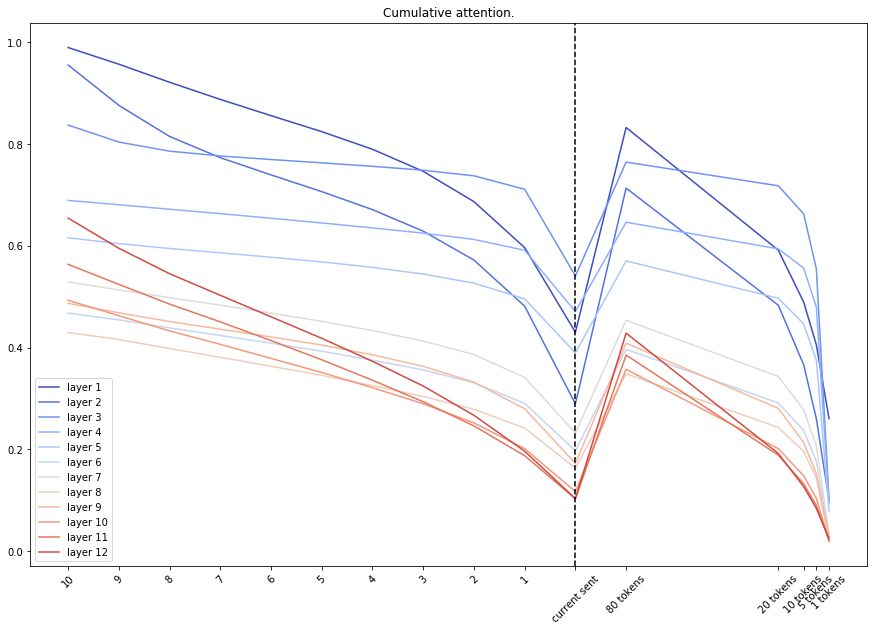

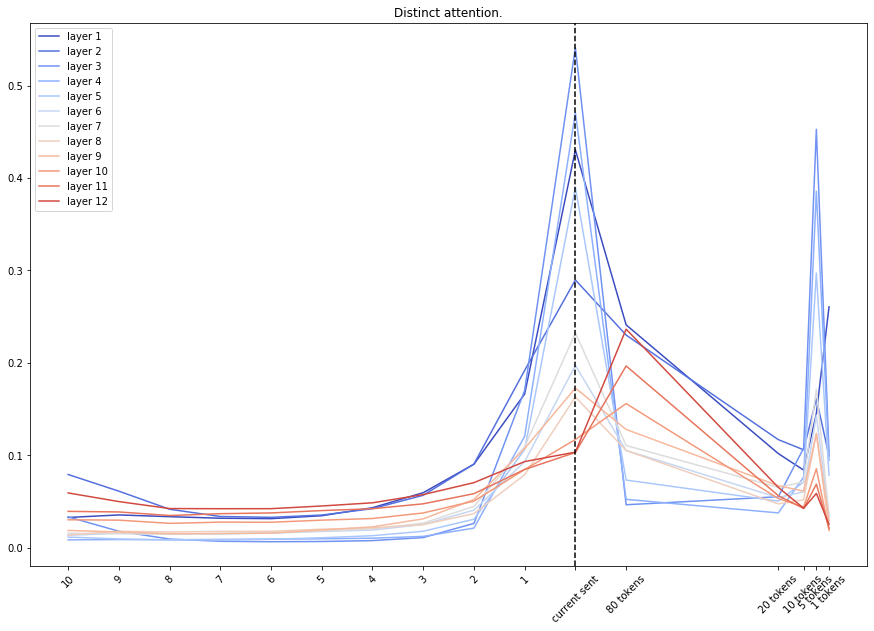

In [15]:
# Per layer
res = []
for i in zip(*attention_weights): #attention_weights[10:]
    attention = np.mean(np.stack([np.mean(np.mean(np.sum(j, axis=-1), axis=-1), axis=1) for j in i], axis=0), axis=0)
    #print(attention.shape)
    res.append(attention)
res = np.stack(res).T
res_cum = np.concatenate([np.flip(np.cumsum(np.flip(res[:, :11], axis=-1), axis=-1), axis=-1), res[:, 11:]], axis=-1)
#print(res.shape)
attention = list(zip(*res))
X = np.hstack([np.arange(12), [14, 14.5, 14.75, 15]])

colormap = plt.cm.coolwarm # gist_heat, coolwarm  
colors = [colormap(i) for i in np.linspace(0, 1, res.shape[0] + 1)]

# Cumulative
fig = plt.figure(figsize=(15, 10))
for i, j in enumerate(res_cum):
    plt.plot(X, j, label=f'layer {i+1}', c=colors[i])
plt.legend()
plt.axvline(x=10, c='black', linestyle='--')
plt.title("Cumulative attention.")
plt.xticks(X, [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, "current sent", '80 tokens', '20 tokens', '10 tokens', '5 tokens', '1 tokens'], rotation=45)
plt.show()

# Distinct attention
fig = plt.figure(figsize=(15, 10))
res = np.concatenate([res[:, :11], np.stack([res[:, i]-res[:, i+1] for i in range(11, 15)], axis=-1), res[:, -1:]], axis=-1)
for i, j in enumerate(res):
    plt.plot(X, j, label=f'layer {i+1}', c=colors[i])
plt.legend()
plt.axvline(x=10, c='black', linestyle='--')
plt.title("Distinct attention.")
plt.xticks(X, [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, "current sent", '80 tokens', '20 tokens', '10 tokens', '5 tokens', '1 tokens'], rotation=45)
plt.show()

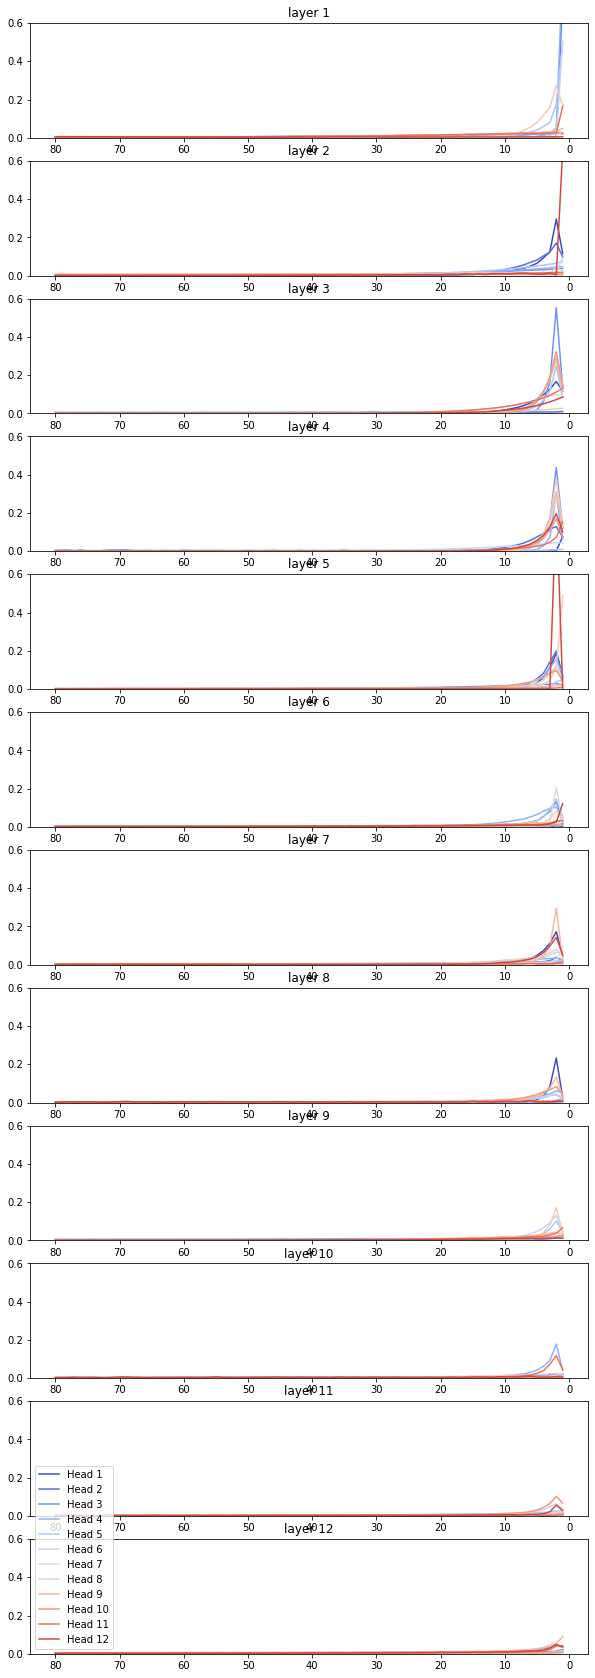

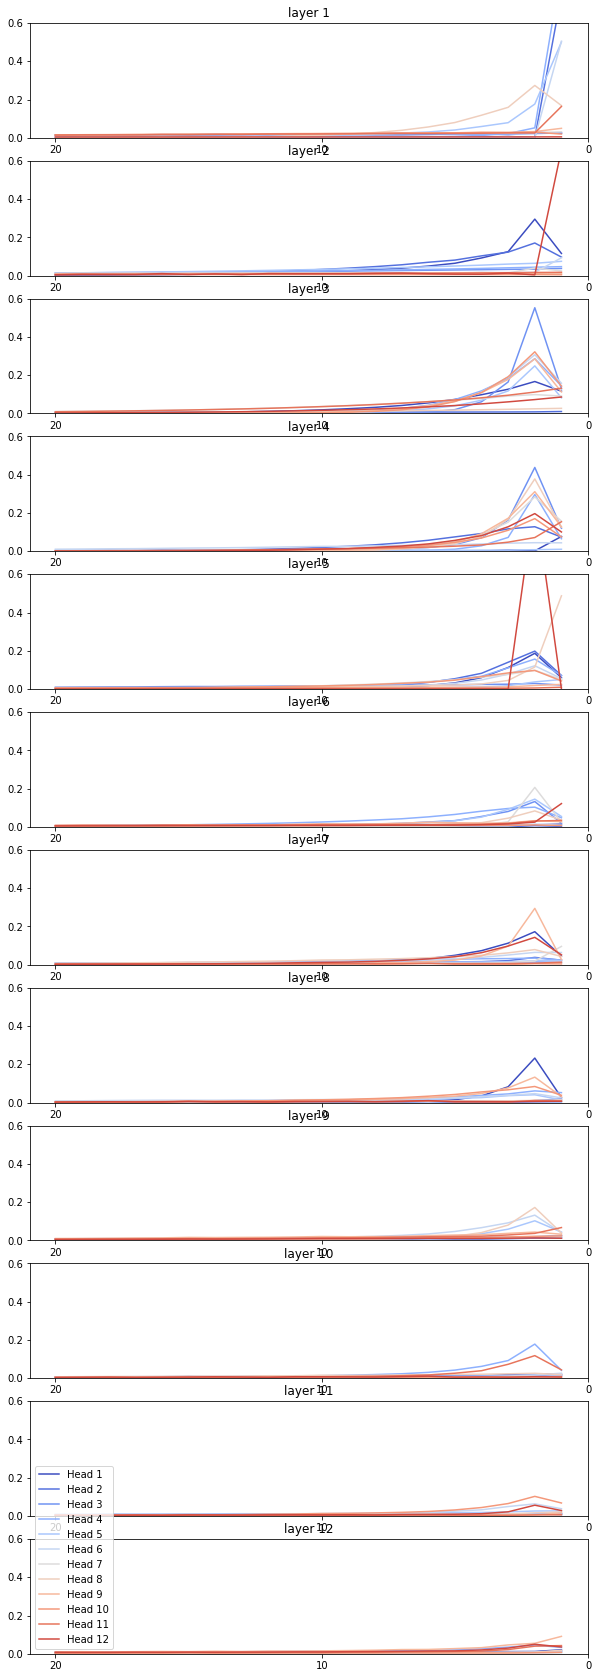

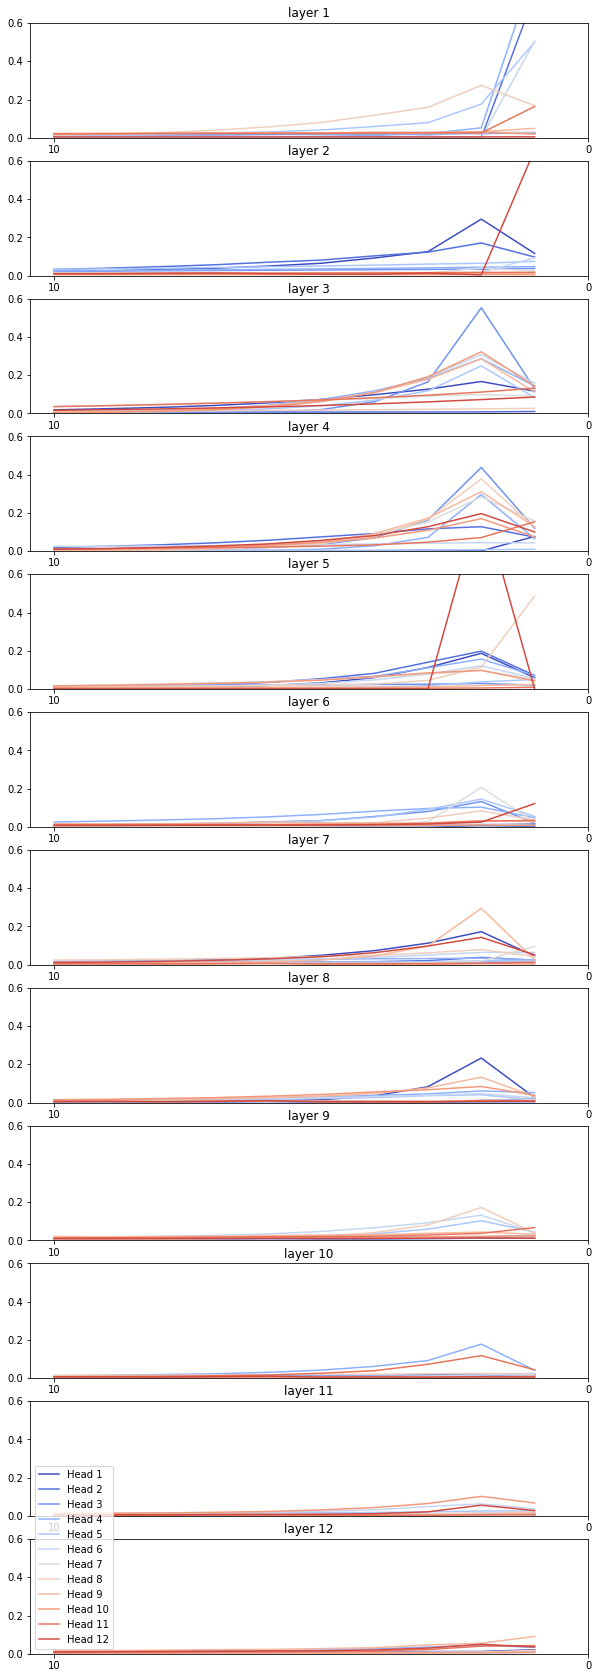

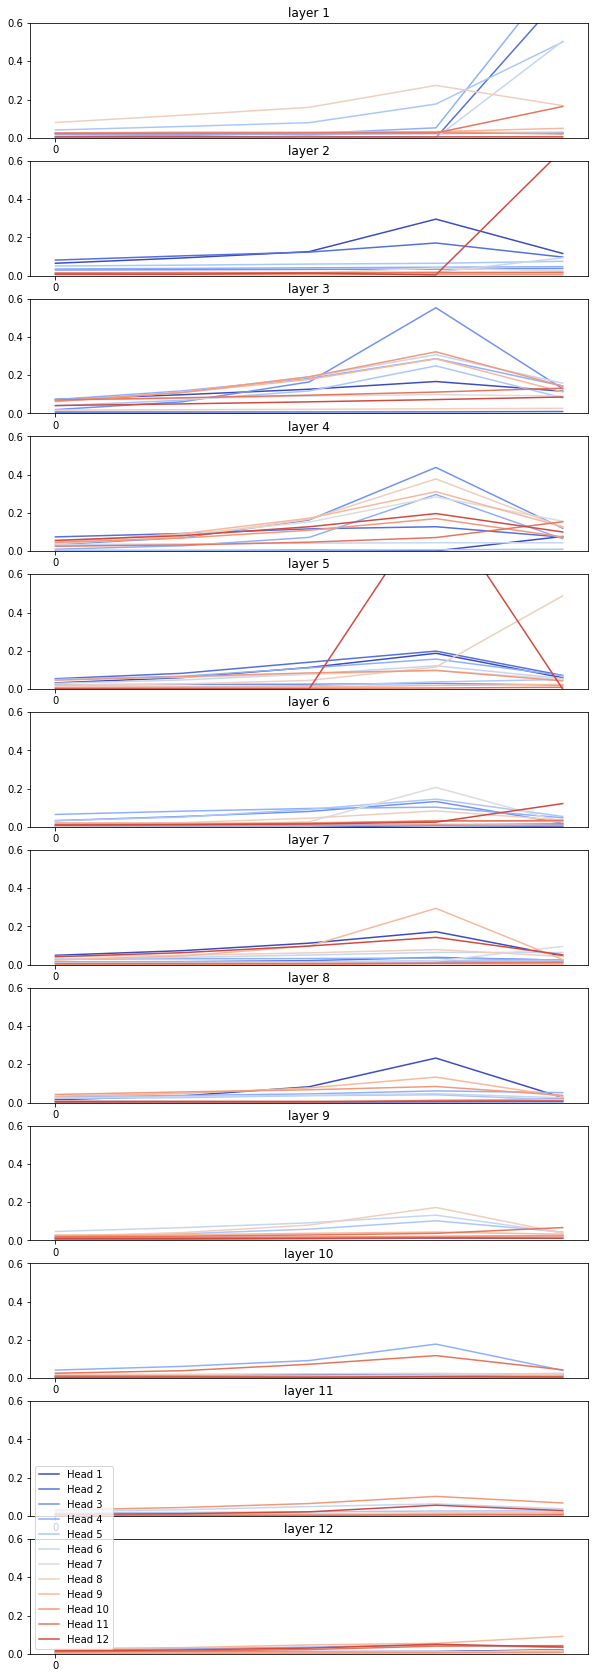

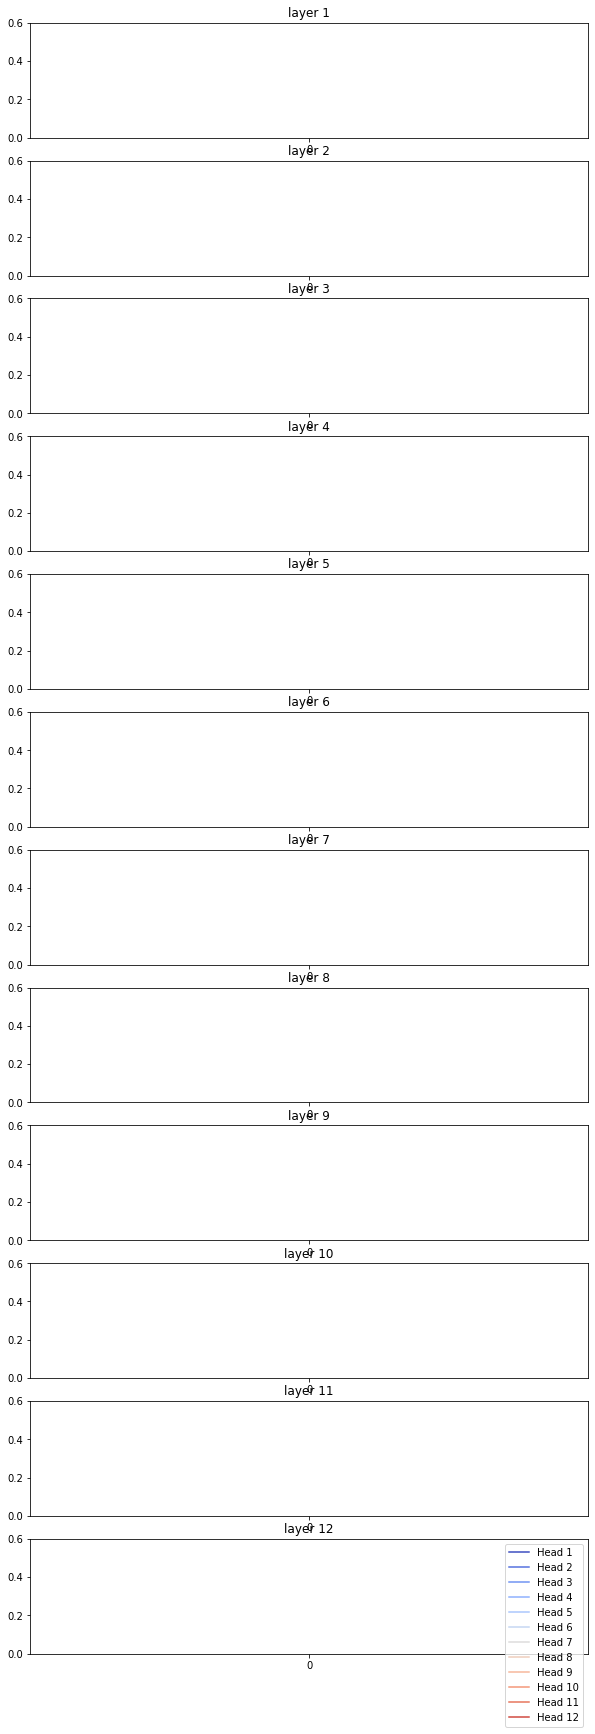

In [16]:


colormap = plt.cm.coolwarm # gist_heat, coolwarm  
colors = [colormap(i) for i in np.linspace(0, 1, 12 + 1)]


for i in list(zip(*attention_weights))[-5:]:
    fig = plt.figure(figsize=(10, 30))
    gs = fig.add_gridspec(12, 1)
    axes = [fig.add_subplot(gs[i, 0]) for i in range(12)]

    tmp = np.mean(np.stack([np.mean(j, axis=-2) for j in i], axis=0), axis=0)
    for j, ax in enumerate(axes):
        for head in range(12):
            ax.plot(tmp[j, head, :], c=colors[head], label=f"Head {head+1}")
        plt.setp(ax, 
                 xticks=np.arange(0, tmp.shape[-1]+1, 10),
                 xticklabels=np.flip(np.arange(0, tmp.shape[-1]+1, 10)),
                )
        ax.set_title(f"layer {j+1}")
    for ax in axes:
        ax.set_ylim((0, 0.6))
    plt.legend()
    plt.show()
#

In [76]:
import seaborn as sns

(11, 12, 12)
(12, 11)
###### LAYER 1 ######


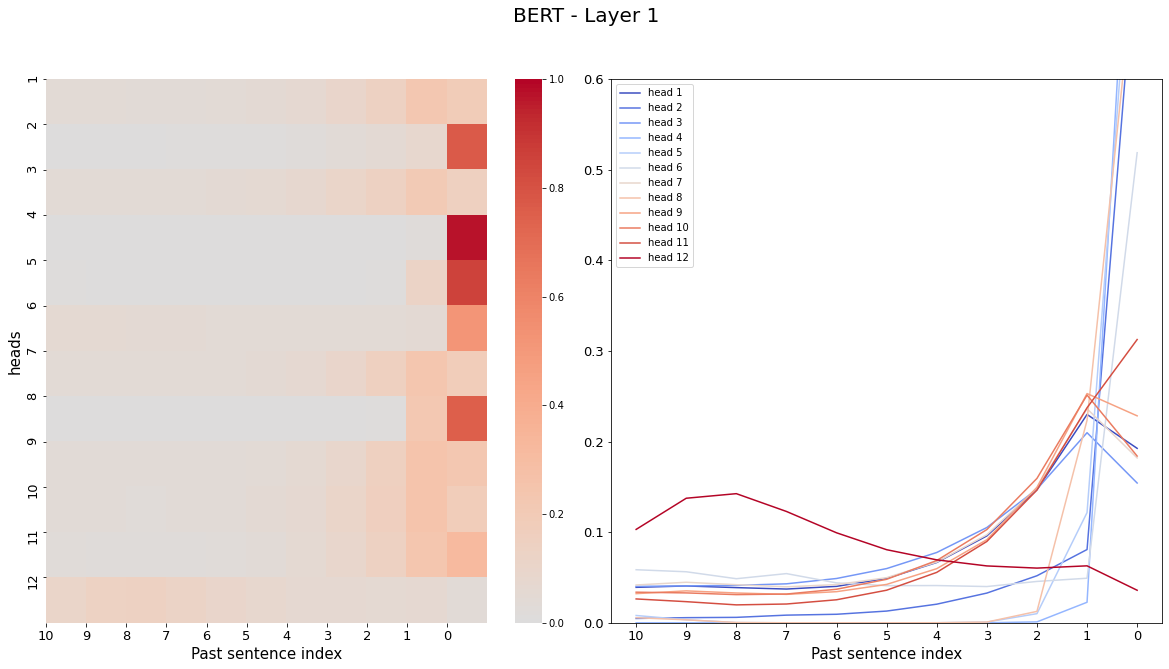



(12, 11)
###### LAYER 2 ######


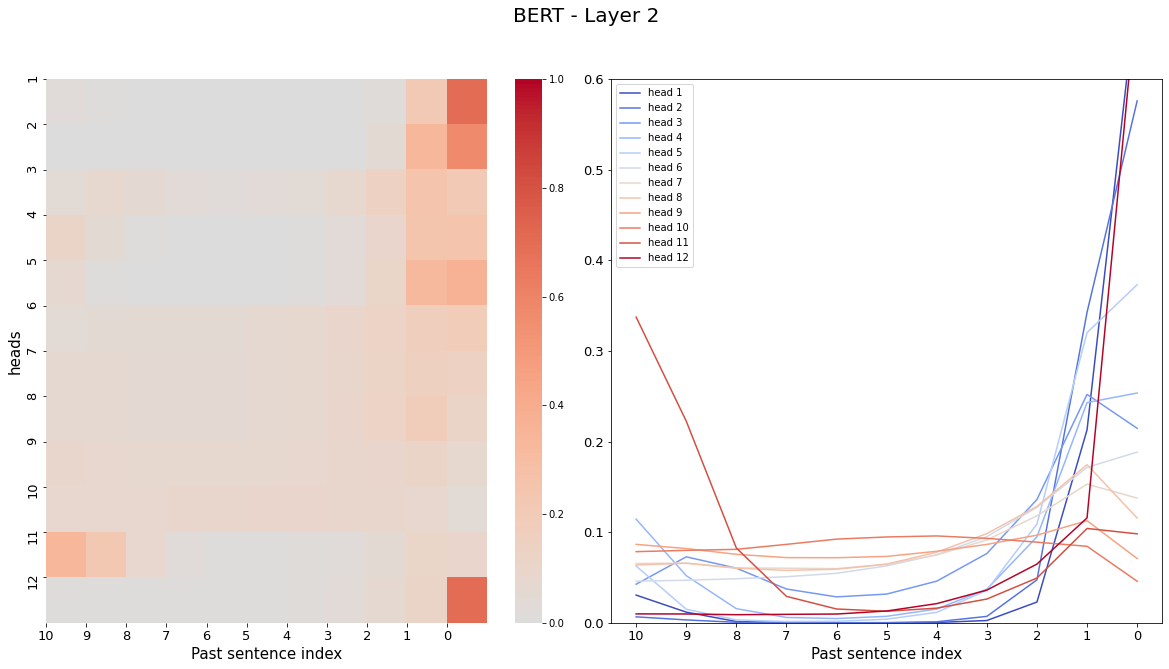



(12, 11)
###### LAYER 3 ######


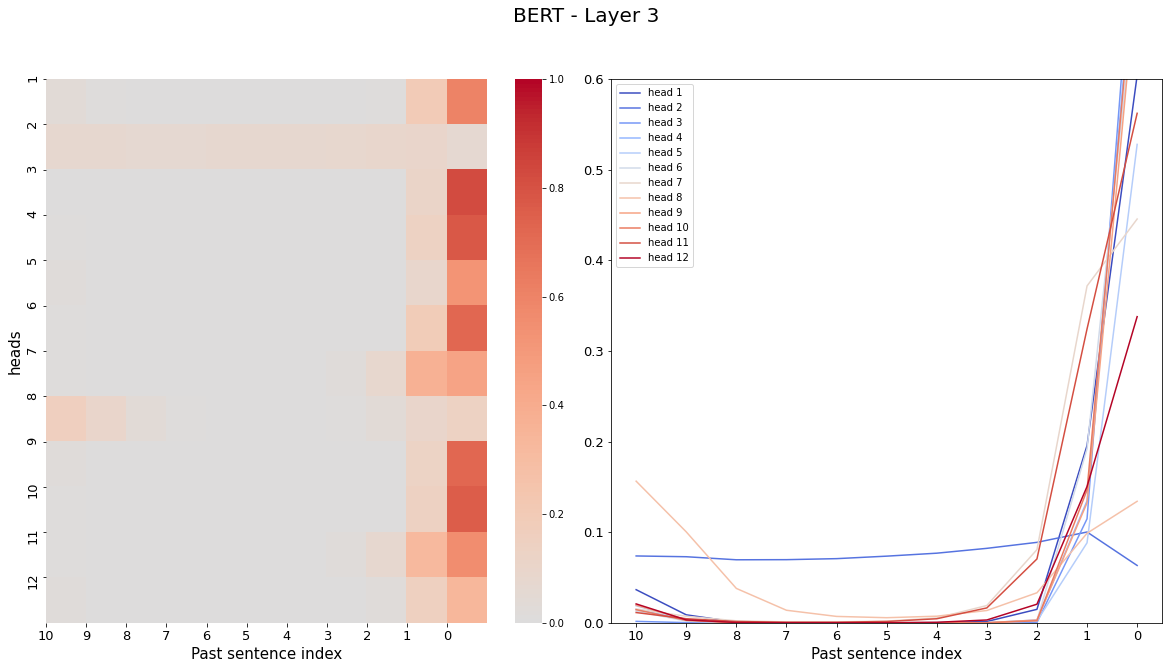



(12, 11)
###### LAYER 4 ######


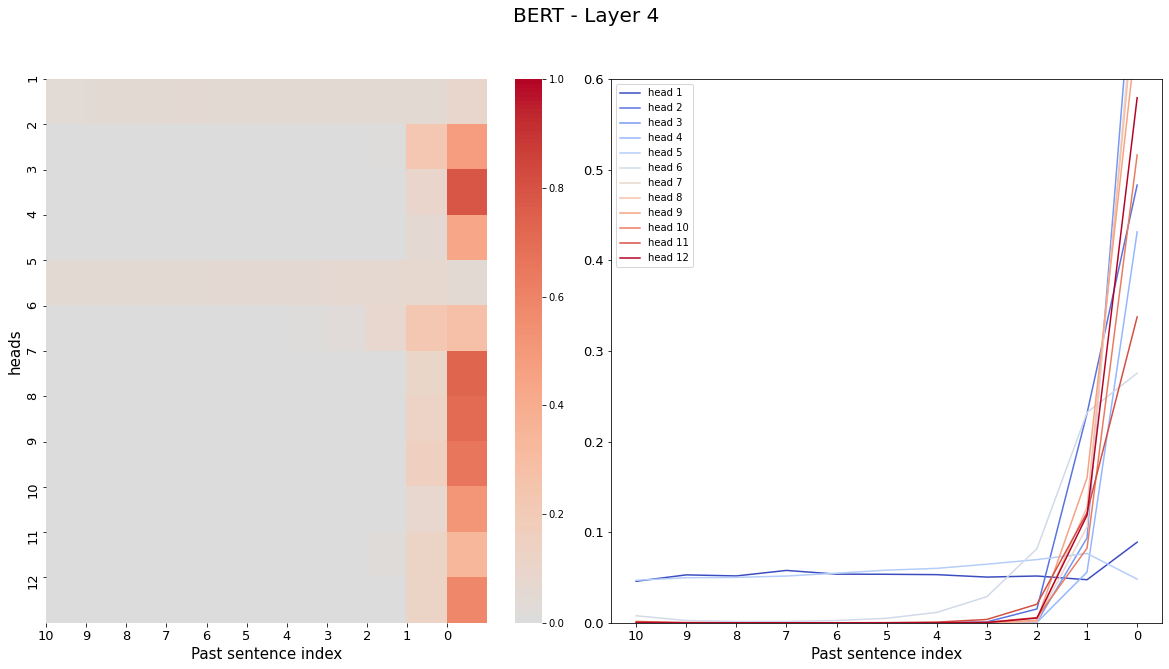



(12, 11)
###### LAYER 5 ######


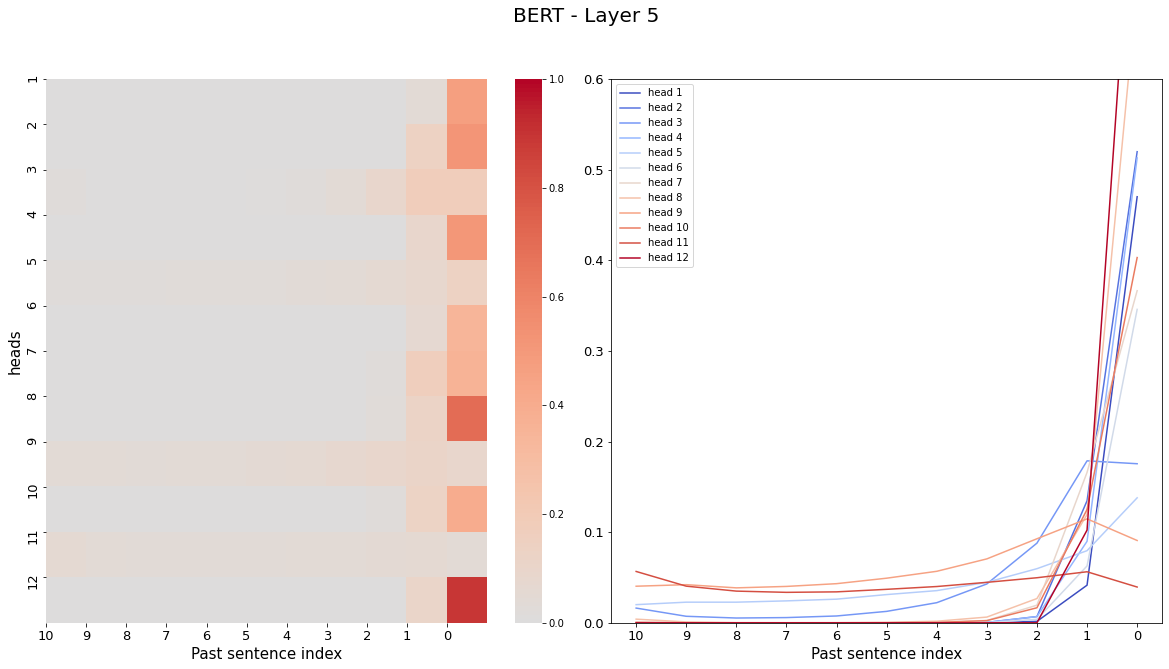



(12, 11)
###### LAYER 6 ######


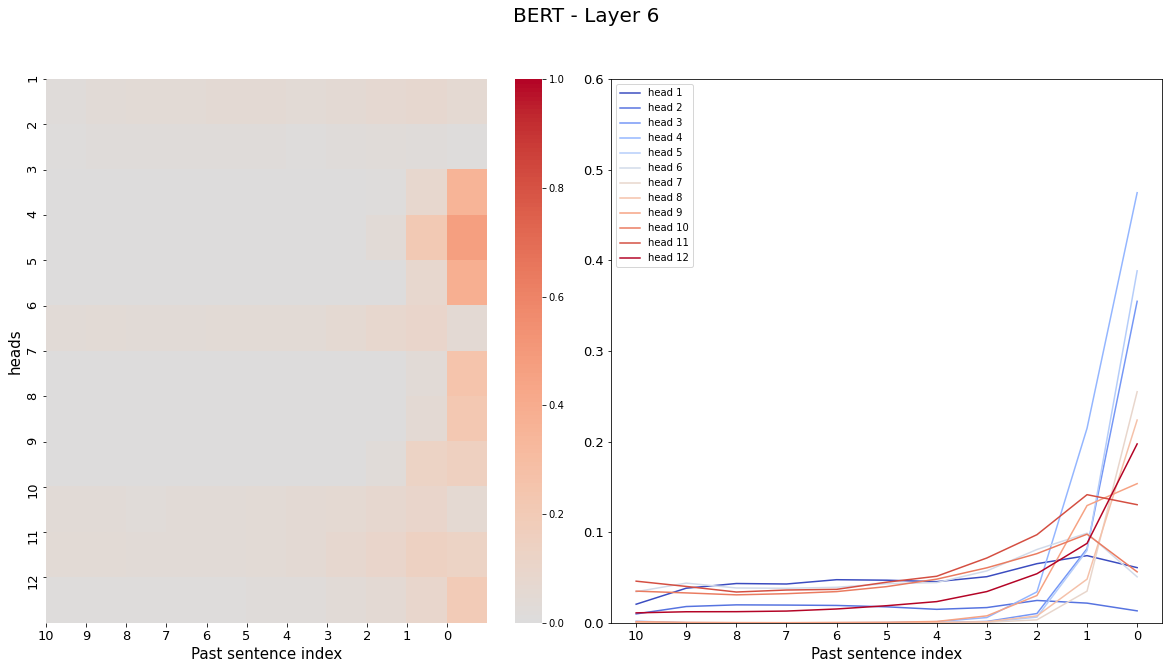



(12, 11)
###### LAYER 7 ######


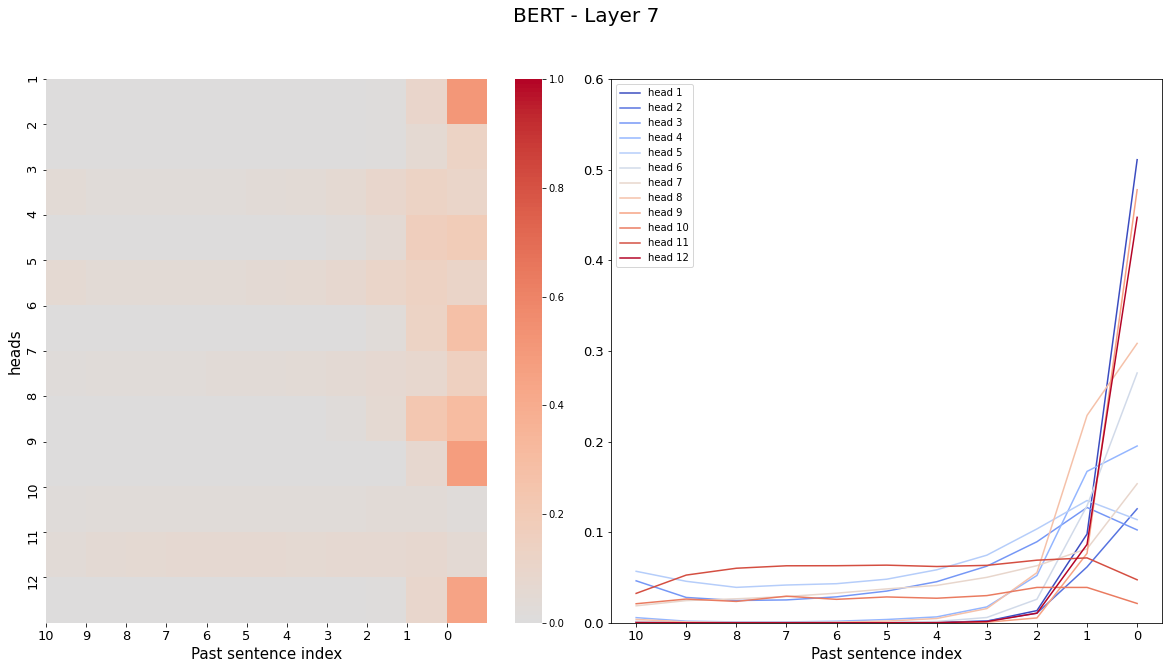



(12, 11)
###### LAYER 8 ######


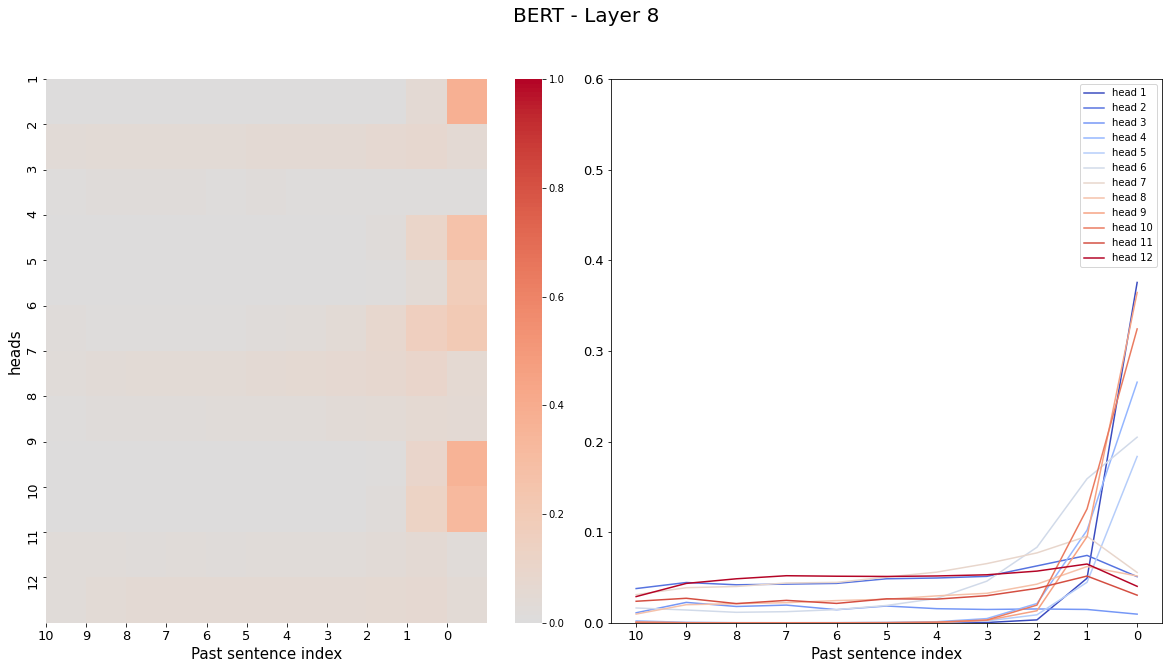



(12, 11)
###### LAYER 9 ######


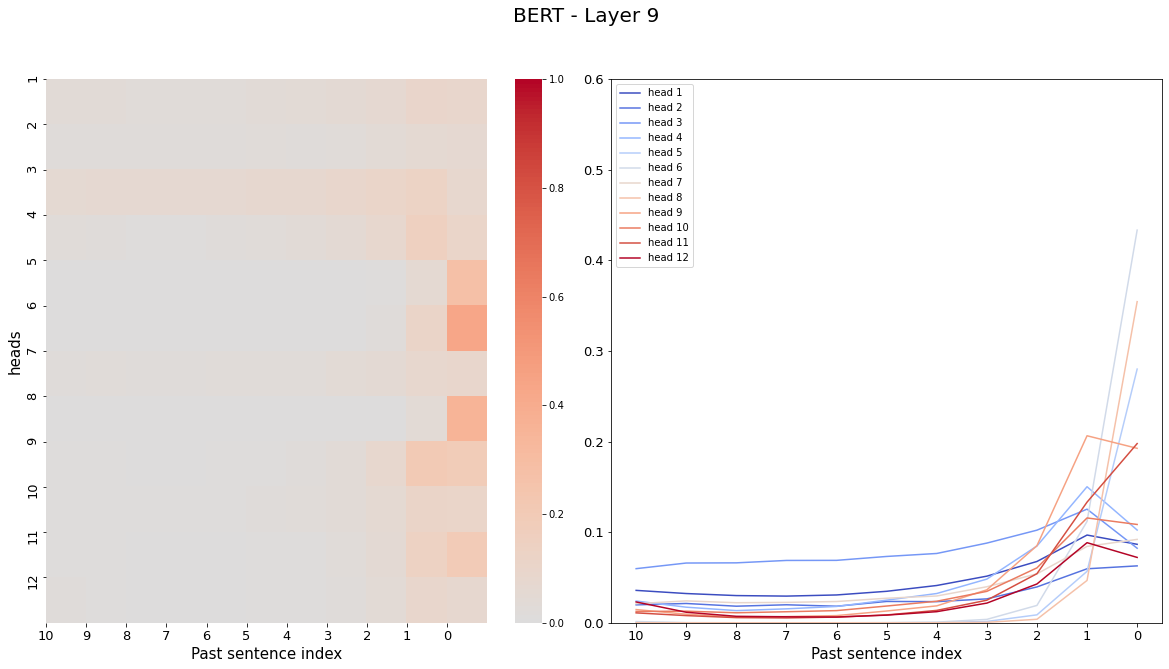



(12, 11)
###### LAYER 10 ######


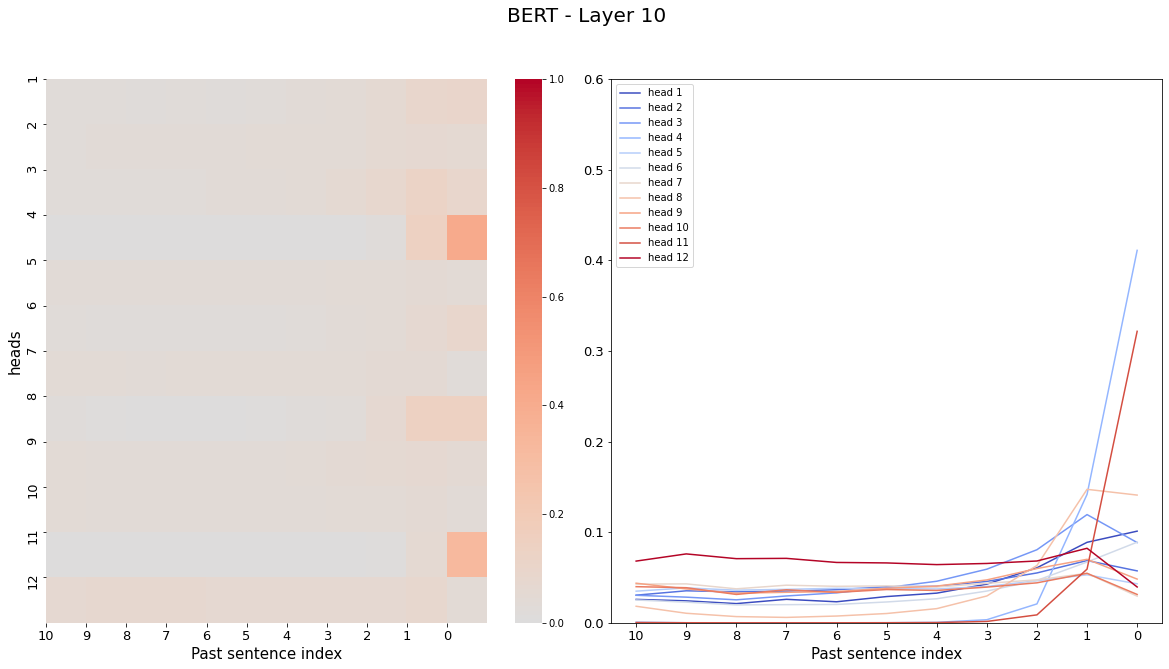



(12, 11)
###### LAYER 11 ######


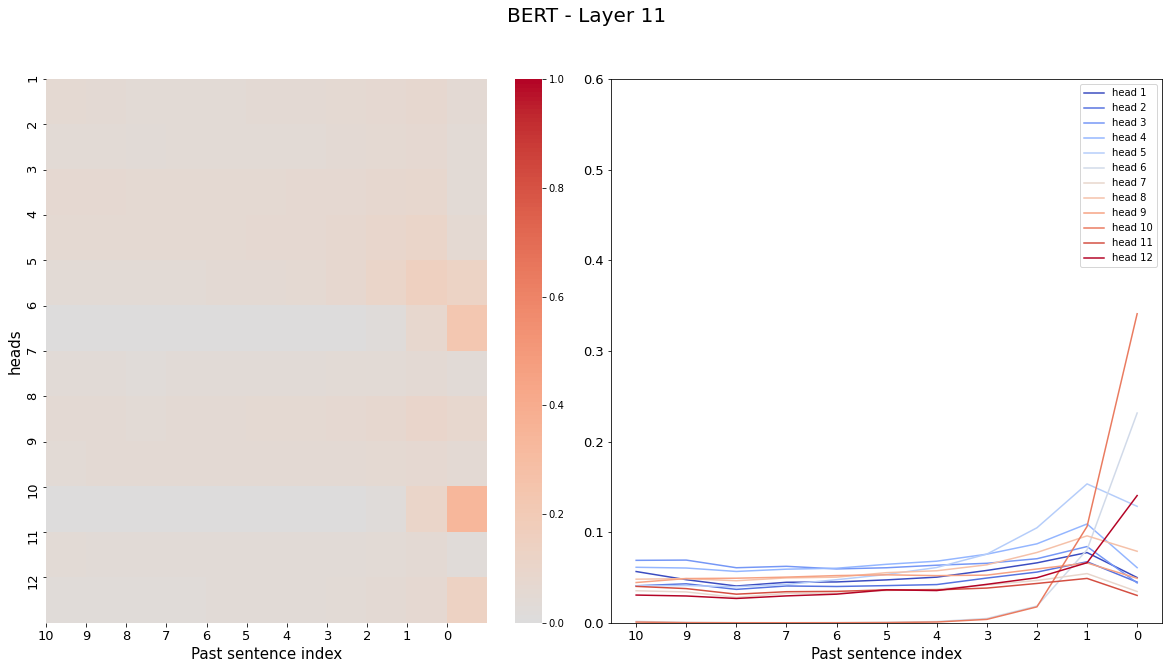



(12, 11)
###### LAYER 12 ######


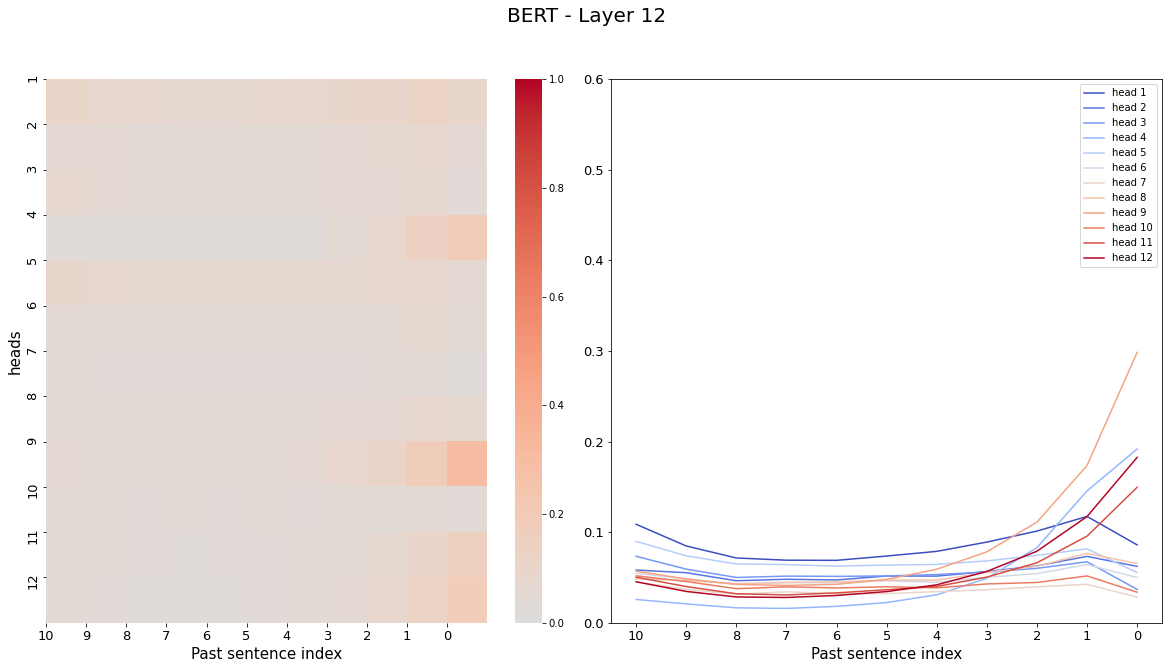

In [79]:
# Per attention-heads
res = []
for i in zip(*attention_weights[10:]):
    attention = np.mean(np.stack([np.mean(np.sum(j, axis=-1), axis=-1) for j in i], axis=0), axis=0)
    #print(attention.shape)
    res.append(attention)
res = np.stack(res, axis=0)
print(res.shape)
for layer in range(res.shape[1]):
    res_tmp = res[:, layer, :].T
    print(res_tmp.shape)
    print(f"###### LAYER {layer+1} ######")
    attention = list(zip(*res_tmp))
    fig = plt.figure(figsize=(20, 10))

    colormap = plt.cm.coolwarm # gist_heat, coolwarm  
    colors = [colormap(i) for i in np.linspace(0, 1, res.shape[0] + 1)]

    gs = fig.add_gridspec(1, 2, width_ratios=[50, 50], wspace=0.025)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    sns.heatmap(res_tmp, ax=ax1, cbar=True, cmap='coolwarm', center=0, vmax=1, vmin=0)
    for i, j in enumerate(res_tmp):
        ax2.plot(j, label=f'head {i+1}', c=colors[i])
    
    ax1.set_ylabel("heads", fontsize=15)
    ax1.set_xlabel("Past sentence index", fontsize=15)
    ax2.set_xlabel("Past sentence index", fontsize=15)
    ax2.set_ylim(0, 0.6)
    plt.legend()
    plt.suptitle(f'BERT - Layer {layer+1}', fontsize=20)
    plt.setp(ax1, 
             xticks=np.arange(11),
             yticks=np.arange(12),
             xticklabels=[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
             yticklabels=np.arange(1, 13),
            )
    ax1.tick_params(axis='x', labelsize=13)
    ax1.tick_params(axis='y', labelsize=13)
    ax2.tick_params(axis='x', labelsize=13)
    ax2.tick_params(axis='y', labelsize=13)
    plt.setp(ax2, 
             xticks=np.arange(11),
             xticklabels=[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
            )
    plt.show()
    print()
    print()

[ 1 41 61 66 71 76 80]


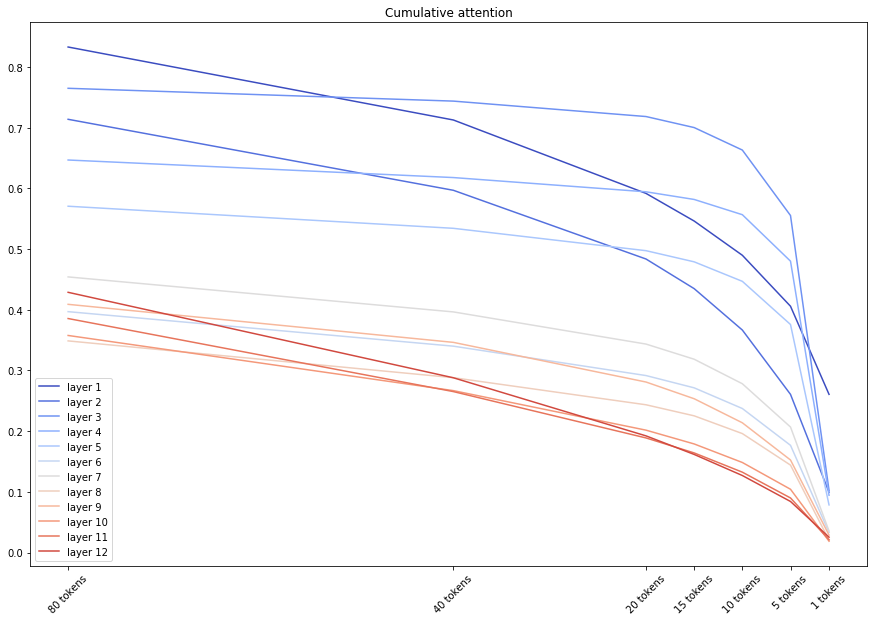

In [61]:
# Per layer
res = []
for i in zip(*attention_weights): #attention_weights[10:]
    attention = np.mean(np.stack([np.mean(np.mean(np.sum(j, axis=-1), axis=-1), axis=1) for j in i], axis=0), axis=0)
    #print(attention.shape)
    res.append(attention)
res = np.stack(res).T
res_cum = np.concatenate([np.flip(np.cumsum(np.flip(res[:, :11], axis=-1), axis=-1), axis=-1), res[:, 11:]], axis=-1)
#print(res.shape)
attention = list(zip(*res))
X = np.flip(- np.array([1, 5, 10, 15, 20, 40, 80]) + 80 + 1)

colormap = plt.cm.coolwarm # gist_heat, coolwarm  
colors = [colormap(i) for i in np.linspace(0, 1, res.shape[0] + 1)]

# Cumulative
fig = plt.figure(figsize=(15, 10))
for i, j in enumerate(res_cum):
    plt.plot(X, j[-7:], label=f'layer {i+1}', c=colors[i])
plt.legend()
plt.title("Cumulative attention")
print(X)
plt.xticks(X, ['80 tokens', '40 tokens', '20 tokens', '15 tokens', '10 tokens', '5 tokens', '1 tokens'], rotation=45)
plt.show()



In [ ]:
# activation generation masked
output = []
activations = []
for index_batch, batch in enumerate(batches_masked):
    batch = batch.strip() # Remove trailing character
    batch = '<|endoftext|> ' + batch + ' <|endoftext|>'

    tokenized_text = tokenizer.tokenize(batch, add_prefix_space=False)
    mapping = gpt2_utils.match_tokenized_to_untokenized(tokenized_text, batch)

    beg = indexes_masked_tmp[index_batch][0] 
    end = indexes_masked_tmp[index_batch][1] 

    inputs_ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_text)])
    inputs_ids = torch.cat(inputs_ids.size(1) * [inputs_ids])
    inputs_ids = inputs_ids[beg:end, :]

    attention_mask =  torch.diag_embed(torch.tensor([0 for x in tokenized_text]))
    for i in range(min(len(tokenized_text), config['attention_length_before'])):
        attention_mask = torch.add(attention_mask, torch.diag_embed(torch.tensor([1 for x in range(len(tokenized_text) - i)]), offset=-i))
    attention_mask = attention_mask[beg:end, :]

    with torch.no_grad():
        encoded_layers = extractor_masked.model(inputs_ids, attention_mask=attention_mask) # last_hidden_state, pooler_output, hidden_states, attentions
        #print(beg, len(tokenized_text) - encoded_layers[2][0].size(0) - 1)
        hidden_states_activations_ = np.vstack([torch.cat([encoded_layers[2][layer][i,len(tokenized_text) - encoded_layers[2][layer].size(0) + i - 1,:].unsqueeze(0) for i in range(encoded_layers[2][layer].size(0))], dim=0).unsqueeze(0).detach().numpy() for layer in range(len(encoded_layers[2]))])
        hidden_states_activations_ = np.concatenate([np.zeros((hidden_states_activations_.shape[0], indexes_masked_tmp[index_batch][0] , hidden_states_activations_.shape[-1])), hidden_states_activations_, np.zeros((hidden_states_activations_.shape[0], len(tokenized_text) - indexes_masked_tmp[index_batch][1], hidden_states_activations_.shape[-1]))], axis=1)
        # retrieve all the hidden states (dimension = layer_count * len(tokenized_text) * feature_count)
            
        #print(len(encoded_layers[2]))
        #print('output shape:', hidden_states_activations_.shape)
        
        new_activations = []
        key = None
        
        #print('Mapping:')
        #for key in mapping.keys():
        #    print(batch.split()[key], ''.join([tokenized_text[i] for i in mapping[key]]))
        #print('A priori Token of interest:', tokenized_text[indexes_masked_tmp[index_batch][0]:indexes_masked_tmp[index_batch][1]])
            
        for key_, value in mapping.items(): 
            if indexes_masked_tmp[index_batch][0] in value:
                key = key_
                
        #print(key)
        #print('dimension match:', len(tokenized_text)==hidden_states_activations_.shape[1])
        tmp = ' '.join([tokenizer.decode(tokenizer.convert_tokens_to_ids([tokenized_text[word] for word in mapping[index]])) for index in range(key, len(mapping.keys()) - 2)])
        tmp = tmp.replace('  ', ' ').strip()
        #print('Extracting sentence:')
        print(tmp)
        output.append(tmp)

        for word_index in range(key, len(mapping.keys()) - 2):
            word_activation = []
            word_activation.append([hidden_states_activations_[:,index, :] for index in mapping[word_index]])
            word_activation = np.vstack(word_activation)
            new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))
        activations.append(new_activations)
        
        #print(np.vstack(new_activations).shape)
        #if input()!='':
        #    break


assert ' '.join(output) == ' '.join(iterator_list[0])


Once , when I was six years old , I saw a magnificent picture in a book about the primeval forest called ‘ Real - life Stories . ’ It showed a boa constrictor swallowing a wild animal . Here is a copy of the drawing . It said in the book : “ Boa constrictors swallow their prey whole , without chewing . Then they are not able to move , and they sleep for the six months it takes for digestion . ” So I thought a lot about the adventures of the jungle and , in turn , I managed , with a coloured pencil , to make my first drawing . My Drawing Number one . It looked like this : I showed my masterpiece to the grownups and I asked them if my drawing frightened them . They answered me : “ Why would anyone be frightened by a hat ? ” My drawing was not of a hat .
It showed a boa constrictor digesting an elephant .
I then drew the inside of the boa constrictor , so that the grownups could understand .
They always need to have things explained .
My Drawing Number two looked like this : The grownups 

In [ ]:
i = 0
for j in activations:
    i+= len(j)
print(i)

In [19]:
# activation generation shuffle
output = []
for index_batch, batch in enumerate(batches_shuffle):
    batch = batch.strip() # Remove trailing character

    batch = '<|endoftext|> ' + batch + ' <|endoftext|>'
    tokenized_text = tokenizer.tokenize(batch, add_prefix_space=False)
    inputs_ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_text)])

    #print('input shape: ', inputs_ids.shape)
    #print(batch)
    #print(tokenized_text)
    
    mapping = utils.match_tokenized_to_untokenized(tokenized_text, batch)

    #print('Mapping:')
    #for key in mapping.keys():
    #    print(batch.split()[key], ''.join([tokenized_text[i] for i in mapping[key]]))
    #print('A priori Token of interest:', tokenized_text[indexes_shuffle[index_batch][0]:indexes_shuffle[index_batch][1]])
         
    with torch.no_grad():
        encoded_layers = extractor_shuffle.model(inputs_ids) # last_hidden_state, pooler_output, hidden_states, attentions

        hidden_states_activations_ = np.vstack(encoded_layers[2]) # retrieve all the hidden states (dimension = layer_count * len(tokenized_text) * feature_count)

        #print('nb of layer:', len(encoded_layers[2]))
        #print('output shape:', hidden_states_activations_.shape)
        
        new_activations = []
        key_start = None
        key_stop = None
        
        #print('Mapping:')
        #for key in mapping.keys():
        #    print(batch.split()[key], ''.join([tokenized_text[i] for i in mapping[key]]))
        #print('A priori Token of interest:', tokenized_text[indexes_masked_tmp[index_batch][0]:indexes_masked_tmp[index_batch][1]])
            
        for key_, value in mapping.items(): 
            if (value[0] - 1) == (indexes_shuffle[index_batch][0]): #because we added [CLS] token at the beginning
                key_start = key_
        for key_, value in mapping.items(): 
            if value[-1] == (indexes_shuffle[index_batch][1]): #because we added [CLS] token at the beginning
                key_stop = key_

        #print(key)
        #print('dimension match:', len(tokenized_text)==hidden_states_activations_.shape[1])
        tmp = ' '.join([tokenizer.decode(tokenizer.convert_tokens_to_ids([tokenized_text[word] for word in mapping[index]])) for index in range(key_start, key_stop + 1)])
        tmp = tmp.replace('  ', ' ').strip()
        #print('Extracting sentence:')
        print(tmp)
        output.append(tmp)
        
        for word_index in range(key_start, key_stop + 1):
            word_activation = []
            word_activation.append([hidden_states_activations_[:,index, :] for index in mapping[word_index]])
            word_activation = np.vstack(word_activation)
            new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))

        
        #print(np.vstack(new_activations).shape)
        #if input()!='':
        #    break


assert ' '.join(output) == ' '.join(iterator_list[0])


Once
,
when
I
was
six
years
old
,
I
saw
a
magnificent
picture
in
a
book
about
the
primeval
forest
called
‘
Real
-
life
Stories
.
’
It
showed
a
boa
constrictor
swallowing
a
wild
animal
.
Here
is
a
copy
of
the
drawing
.
It
said
in
the
book
:
“
Boa
constrictors
swallow
their
prey
whole
,
without
chewing
.
Then
they
are
not
able
to
move
,
and
they
sleep
for
the
six
months
it
takes
for
digestion
.
”
So
I
thought
a
lot
about
the
adventures
of
the
jungle
and
,
in
turn
,
I
managed
,
with
a
coloured
pencil
,
to
make
my
first
drawing
.
My
Drawing
Number
one
.
It
looked
like
this
:
I
showed
my
masterpiece
to
the
grownups
and
I
asked
them
if
my
drawing
frightened
them
.
They
answered
me
:
“
Why
would
anyone
be
frightened
by
a
hat
?
”
My
drawing
was
not
of
a
hat
.
It
showed
a
boa
constrictor
digesting
an
elephant
.
I
then
drew
the
inside
of
the
boa
constrictor
,
so
that
the
grownups
could
understand
.
They
always
need
to
have
things
explained
.
My
Drawing
Number
two
looked
like
this
:
The
grownups


said
gravely
:
“
That
doesn
’
t
matter
;
where
I
live
,
everything
is
so
small
!
”
And
perhaps
with
a
hint
of
sadness
,
he
added
:
“
Straight
ahead
you
can
'
t
go
far
...
”


In [45]:
def transform_sentence_and_context(
    iterator, 
    past_context_size, 
    pretrained_model,
    transformation='shuffle',
    vocabulary=None,
    dictionary=None,
    select=None,
    seed=1111,
    add_prefix_space=True):
    """ Given a list of sentences, for each word, we transform its context outside a certain context window.
    Args:
        - iterator: list (of str)
        - context_size: int
        - pretrained_model: str
        - vocabulary: list
        - dictionary: dict
        - seed: int
        - add_prefix_space: bool
    Returns:
        - batch_tmp: list (of str)
        - index_tmp: list (of tuple of int)
    """
    random.seed(seed)
    punctuation = ['.', '!', '?', '...', '\'', ',', ';', ':', '/', '-', '"', '‘', '’', '(', ')', '{', '}', '[', ']', '`', '“', '”', '—']
    if select is None:
        words = ' '.join(iterator).split()
    else:
        words = iterator[select].split()
        
    all_words = ' '.join(iterator).split()
    words_before = [] if select is None else ' '.join(iterator[:select]).split()
    supp_before = [len([word for word in all_words[max(j+len(words_before)+1-past_context_size, 0):j+len(words_before)+1] if word in punctuation]) for j in range(len(words))] # we do not count punctuation in the number of words to shuffle

    # For each word, we compute the index of the other words to transform
    # We transform past context. Change conditions "i<j" and ... to something else if needed
    index_words_list_before = [[i for i, item in enumerate(all_words) if item not in punctuation if ((i!=(j+len(words_before))) and  (i <= j+len(words_before)-past_context_size-supp_before[j]))] for j in range(len(words))] # '<=' because context_size of 1 is the current word

    # Create the new array of sentences with original words 
    new_words = np.tile(np.array(all_words.copy()), (len(words), 1))

    for i in range(len(new_words)):
        if len(index_words_list_before[i])>0: # if there are words to change...
            if transformation=='shuffle':
                # Replace words that need to be shuffled by the random sampling (except fix point and punctuation)
                new_order = random.sample(index_words_list_before[i], len(index_words_list_before[i]))
                if len(index_words_list_before[i])>1:
                    while new_order==index_words_list_before[i]:
                        new_order = random.sample(index_words_list_before[i], len(index_words_list_before[i]))
                new_words[i, index_words_list_before[i]] = new_words[i, new_order]
            elif transformation=='pos_replacement':
                # Replace words that need to be replaced by words with same POS (except fix point and punctuation)
                new_words[i, index_words_list_before[i]] = pick_pos_word(new_words[i, index_words_list_before[i]], dictionary)
            elif transformation=='random_replacement':
                # Replace words that need to be replaced by random words (except fix point and punctuation)
                new_words[i, index_words_list_before[i]] = pick_random_word(new_words[i, index_words_list_before[i]], vocabulary)

    # Convert array to list
    new_words = list(new_words)
    new_words = [list(item) for item in new_words]
    batch_tmp = []
    index_tmp = []
    tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model) # to replace with tokenizer of interest
    # adding transformed context to each sentence
    for i, sentence in enumerate(new_words):
        batch_tmp.append(' '.join(sentence).strip())
        # Determining associated indexes
        tmp1 = ' '.join(sentence[:i+len(words_before)])
        tmp2 = ' '.join(sentence[:i+len(words_before)+1])
        index_tmp.append((len(tokenizer.tokenize(tmp1.strip(), add_prefix_space=add_prefix_space)), 
                     len(tokenizer.tokenize(tmp2.strip(), add_prefix_space=add_prefix_space))
                    )) # to replace with tokenizer of interest and arguments
    return batch_tmp, index_tmp

In [48]:
iterator= iterator_list[0]
number_of_sentence=config['number_of_sentence']
number_sentence_before=config['number_of_sentence_before']
pretrained_model='gpt2'
past_context_size=config['attention_length_before']
transformation='shuffle'
vocabulary=None
dictionary=None
seed=1111
max_length=512
add_prefix_space=True


iterator = [item.strip() for item in iterator]
max_length -= 3 # for special tokens, because there is a G (dot) before last special token
assert number_of_sentence > 0
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model)

batch = []
indexes = []
sentence_count = 0
n = len(iterator)


print('entering while loop...')
# rest of the iterator + context 
while sentence_count < n:
    start = max(sentence_count - number_sentence_before, 0)
    stop = min(sentence_count + number_of_sentence, n)
    token_count = len(tokenizer.tokenize(' '.join(iterator[start:stop]), add_prefix_space=add_prefix_space)) # to replace with tokenizer of interest and arguments
    if token_count > max_length:
        raise ValueError('Cannot fit context with additional sentence. You should reduce context length.')
    # computing batch and indexes
    print(len(iterator[start:stop]))
    print(iterator[start:stop])
    
    batch_tmp, index_tmp = transform_sentence_and_context(
        iterator[start:stop], 
        past_context_size=past_context_size,
        pretrained_model=pretrained_model,
        transformation=transformation,
        vocabulary=vocabulary,
        dictionary=dictionary,
        select=stop-start-1,
        seed=seed,
        add_prefix_space=add_prefix_space
    )
    print('result:')
    for b in batch_tmp:
        print(b)
    batch += batch_tmp
    indexes += index_tmp
    sentence_count = stop
    print(stop-start-1)
    if input()!='':
        break

#for b in batch:
#    print(b)
#print(indexes)

entering while loop...
1
['Once , when I was six years old , I saw a magnificent picture in a book about the primeval forest called ‘ Real - life Stories . ’']
result:
Once , when I was six years old , I saw a magnificent picture in a book about the primeval forest called ‘ Real - life Stories . ’
Once , when I was six years old , I saw a magnificent picture in a book about the primeval forest called ‘ Real - life Stories . ’
Once , when I was six years old , I saw a magnificent picture in a book about the primeval forest called ‘ Real - life Stories . ’
Once , when I was six years old , I saw a magnificent picture in a book about the primeval forest called ‘ Real - life Stories . ’
when , Once I was six years old , I saw a magnificent picture in a book about the primeval forest called ‘ Real - life Stories . ’
I , Once when was six years old , I saw a magnificent picture in a book about the primeval forest called ‘ Real - life Stories . ’
I , was Once when six years old , I saw a magn

result:
a , in Stories a It swallowing years , is the animal I called magnificent life showed was book six forest Here ‘ saw - when picture . ’ I Real boa the copy constrictor primeval wild a . a Once of old about a drawing . It said in the book : “ Boa constrictors swallow their prey whole , without chewing .
swallowing , forest book saw drawing about I , when wild years boa called Stories old in magnificent a picture constrictor Real ‘ the - primeval I . ’ a It of six Here the a a a . showed was animal life Once copy is . It said in the book : “ Boa constrictors swallow their prey whole , without chewing .
saw , about showed called a drawing magnificent , copy years of the picture wild a Real Here boa I a is ‘ animal - swallowing It . ’ a was Once Stories It six forest life primeval . in a old when constrictor the I . book said in the book : “ Boa constrictors swallow their prey whole , without chewing .
about , It forest Real constrictor magnificent called , said is I six picture a 

In [ ]:
files = sorted(glob.glob(os.path.join(
    '/Volumes/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english', 
    'gpt2_pre-10_1_norm-2/activations_*')))
data = [pd.read_csv(file_) for file_ in files]

  0%|          | 0/9 [00:00<?, ?it/s]

(1894, 768)
(1939, 768)
(1894, 1218)


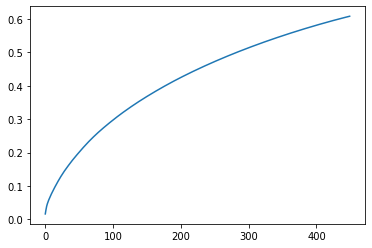

 11%|█         | 1/9 [00:06<00:54,  6.83s/it]

(2093, 768)
(2138, 768)
(2093, 1218)


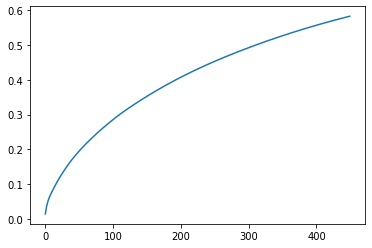

 22%|██▏       | 2/9 [00:14<00:49,  7.10s/it]

(2297, 768)
(2342, 768)
(2297, 1218)


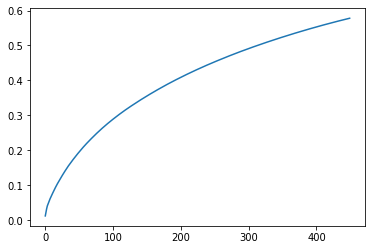

 33%|███▎      | 3/9 [00:22<00:43,  7.28s/it]

(2152, 768)
(2197, 768)
(2152, 1218)


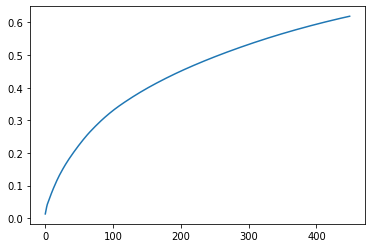

 44%|████▍     | 4/9 [00:29<00:36,  7.26s/it]

(2065, 768)
(2110, 768)
(2065, 1218)


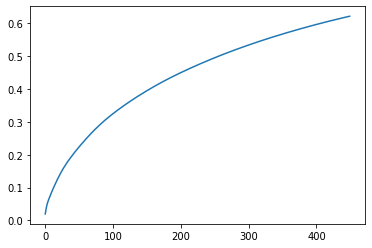

 56%|█████▌    | 5/9 [00:36<00:28,  7.20s/it]

(2404, 768)
(2449, 768)
(2404, 1218)


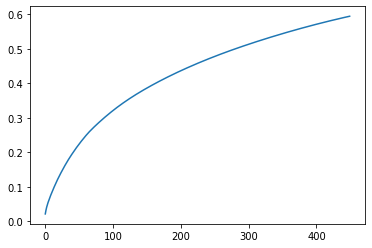

 67%|██████▋   | 6/9 [00:44<00:22,  7.39s/it]

(2435, 768)
(2480, 768)
(2435, 1218)


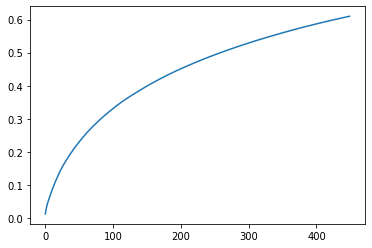

 78%|███████▊  | 7/9 [00:52<00:15,  7.58s/it]

(2038, 768)
(2083, 768)
(2038, 1218)


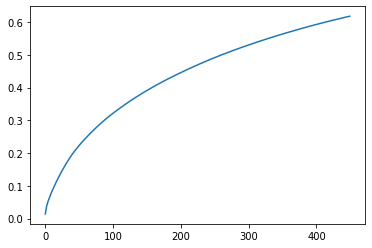

 89%|████████▉ | 8/9 [00:59<00:07,  7.43s/it]

(2530, 768)
(2575, 768)
(2530, 1218)


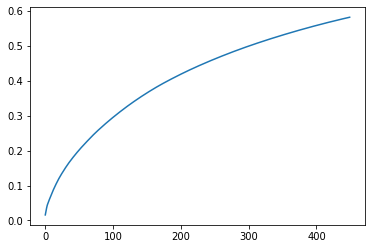

100%|██████████| 9/9 [01:07<00:00,  7.51s/it]


In [72]:

SEED = 1111
context_size = 45
columns = [f'hidden_state-layer-10-{unit}' for unit in range(1, 769)]
for tmp in tqdm(data):
    tmp = tmp[columns]
    values = tmp.values
    print(values.shape)

    values_padded = np.vstack([np.zeros((context_size, 768)), values])
    print(values_padded.shape)
    result = []
    for i in range(context_size, values_padded.shape[0]):
        result.append(np.hstack(values_padded[i-context_size:i, :])) #[np.hstack(values_padded[i-context_size:i, :]), values_padded[i, :]]


    test = np.stack(result, axis=0)
    pca = PCA(n_components=450, random_state=SEED)
    transf = pca.fit_transform(test)
    activations = np.hstack([values, transf])
    print(activations.shape)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.show()

In [73]:
np.cumsum(pca.explained_variance_ratio_)

array([0.01600354, 0.02714427, 0.03650831, 0.04444337, 0.04982923,
       0.05496292, 0.06009136, 0.06492043, 0.06973393, 0.07454407,
       0.07920858, 0.08386706, 0.08835504, 0.09261265, 0.09674188,
       0.10085216, 0.1049012 , 0.10881847, 0.11265399, 0.11648817,
       0.12004929, 0.12353599, 0.12692346, 0.13023631, 0.13345727,
       0.13661728, 0.1397688 , 0.14290981, 0.14600102, 0.14892122,
       0.15182519, 0.15472725, 0.15758365, 0.1604068 , 0.16321898,
       0.16589423, 0.16851971, 0.17114376, 0.17368728, 0.1762254 ,
       0.1787407 , 0.1811878 , 0.18363247, 0.18605169, 0.18842796,
       0.1907885 , 0.19314153, 0.19546794, 0.19777768, 0.20005863,
       0.20233515, 0.20456273, 0.20674123, 0.20890571, 0.21104845,
       0.21316203, 0.21526702, 0.21736503, 0.21945883, 0.2215444 ,
       0.22361458, 0.22566904, 0.22772103, 0.22977183, 0.23181608,
       0.23385339, 0.23587419, 0.23787641, 0.23986718, 0.24185015,
       0.24382548, 0.24577785, 0.24768817, 0.24957726, 0.25145

(1894, 768)
(1939, 768)
(1909, 768)
(1894, 34560)
(1894, 1218)


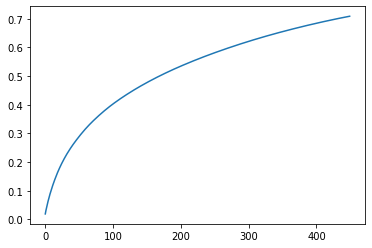

In [78]:

SEED = 1111

columns = [f'hidden_state-layer-10-{unit}' for unit in range(1, 769)]
tmp = data[0]
tmp = tmp[columns]
values = tmp.values
print(values.shape)

context_size = 45
values_padded = np.vstack([np.zeros((context_size, 768)), values])
print(values_padded.shape)
result = []
for i in range(context_size, values_padded.shape[0]):
    result.append(np.hstack(values_padded[i-context_size:i, :])) #[np.hstack(values_padded[i-context_size:i, :]), values_padded[i, :]]
test = np.stack(result, axis=0)
pca = PCA(n_components=450, random_state=SEED)
transf = pca.fit_transform(test)

####
context_size = 15
values_padded = np.vstack([np.zeros((context_size, 768)), values])
print(values_padded.shape)
result = []
for i in range(context_size, values_padded.shape[0]):
    result.append(np.hstack([np.hstack(values_padded[i-context_size:i, :]), np.zeros(30*768)])) #[np.hstack(values_padded[i-context_size:i, :]), values_padded[i, :]]
test = np.stack(result, axis=0)
print(test.shape)
t1 = pca.transform(test)
t2 = pca.fit_transform(test)

####

activations = np.hstack([values, transf])
print(activations.shape)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [80]:
print(t1.shape)
print(t2.shape)

(1894, 450)
(1894, 450)


In [89]:

from scipy.stats import pearsonr
from sklearn.metrics import r2_score

for i in range(450):
    print(pearsonr(t1[:, i], t2[:, i])[0]*100)

-89.53449432274763
-56.97327332531156
5.755859520235394
12.62061507721383
20.89910185979928
46.962708499599074
7.869143998303192
-0.830620609970629
9.482632993852944
-5.068326667957878
-2.7125527055880982
28.328132342627065
-7.285048955391127
19.06319321439461
-3.8336046910928263
7.3908661781060925
3.374646561229117
-2.62309749978848
9.667617619697904
4.828454040842199
7.198487999426427
10.786217983364658
38.80516447193198
1.722573673130149
-0.9206957105918419
-5.171327419408798
-1.279004920151586
1.0565487943367333
-2.333518230685528
3.2447506115451157
-3.607258245748035
1.3390726452819384
4.373402188631993
-2.8179908965205667
-2.31815850413393
-0.10399545204101227
3.9640335901764545
6.9020983739546615
3.201619873599828
0.12131461239301747
-0.65850207209265
2.33147853537151
4.542659382166902
0.3898816945921509
-8.837650984271338
-0.5946894834296111
2.386885269767617
-12.573724837000096
-3.019761109419162
1.8236649946923515
3.8906542324429556
-5.732792909383775
-2.6448692824146627
-0.3